In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Set parameters for visualization
a = 20  # Start range for y-axis
b = 100  # End range for y-axis
c = 14  # The x-value to move to x=0
d = 1  # The threshold for Gauss Curvature
e = 8  # The threshold for WSS

### CB可视化（包括mapping）

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


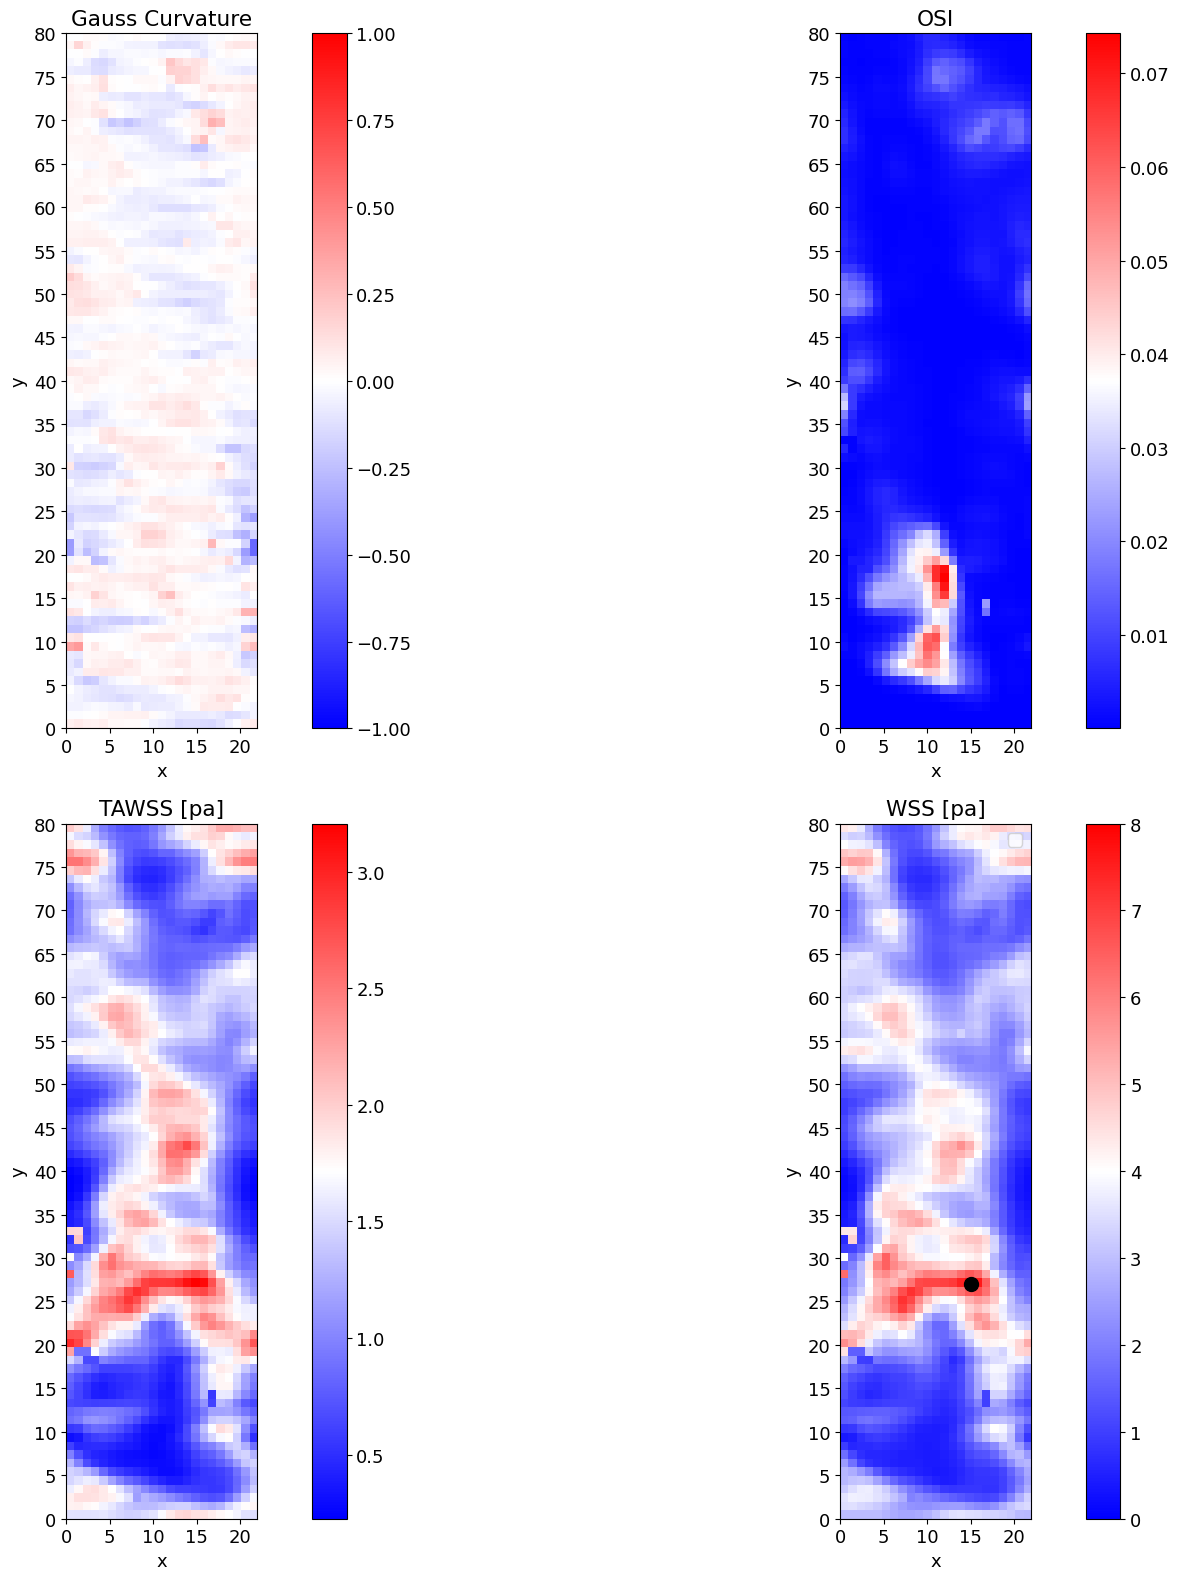

Max WSS value: 7.74759
Max WSS coordinates: (15, 27)


In [88]:
# Load the CSV file for analysis
file_path = 'CB_kabayaki.csv'  # 请替换为你的实际文件路径
df = pd.read_csv(file_path)

# Filter y values in the range of a and b
df_filtered = df[(df['y'] >= a) & (df['y'] <= b)].copy()
df_filtered['y'] = df_filtered['y'] - a  # Adjust y values so that 'a' becomes 0

# Process the mapping: flip x-axis and adjust to start from 0
df_c_to_max = df_filtered[df_filtered['x'] >= c].copy()
df_c_to_max['x'] = df_c_to_max['x'] - c  # Move these x values to 0
df_0_to_c = df_filtered[df_filtered['x'] < c].copy()
df_0_to_c['x'] = df_0_to_c['x'] + (df['x'].max() - c + 1)  # Shift these x values to the right

# Flip x-axis values for reverse order
df_c_to_max['x'] = (df['x'].max() - c) - df_c_to_max['x']
df_0_to_c['x'] = (df['x'].max() - c) - df_0_to_c['x']

# Merge the data back together
df_mapped = pd.concat([df_c_to_max, df_0_to_c])

# Handle duplicate entries by averaging the values for duplicate x-y pairs
df_mapped = df_mapped.groupby(['y', 'x'], as_index=False).mean()

# Pivot the dataframe to create 2D arrays for each parameter
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x', values='WSS [pa]').values

# Create a custom colormap: white at 0, blue for lower values, red for higher values
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Find the position of the maximum WSS value and its coordinates based on the new y-axis
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (wss_max_index[1], wss_max_index[0])

# Create a list of titles and grids for plotting
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

# Plot each parameter as a separate subplot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(19, 16))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # Set vmin and vmax for Gauss Curvature to limit the range to -d to d
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-d, vmax=d, extent=(0, len(grid[0]) - 1, 0, b - a))
    elif title == 'WSS [pa]':
        # Set vmin and vmax for WSS
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=e, extent=(0, len(grid[0]) - 1, 0, b - a))
        #ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10)
        ax.legend()
    else:
        # Plot other parameters without limiting the range
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(0, len(grid[0]) - 1, 0, b - a))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Set axis ticks at intervals of 5
    ax.set_xticks(np.arange(0, len(grid[0]), 5))
    ax.set_yticks(np.arange(0, b - a + 1, 5))
    
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# Output max WSS value and coordinates
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")


### CB mapping后csv输出

In [42]:
# 为 `df_mapped` 中的 `x` 轴创建新的翻转列 `x_flipped`
df_mapped['x_flipped'] = (df_mapped['x'].max() - df_mapped['x']).astype(int)

# 生成网格数据，使用翻转后的 x 轴
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x_flipped', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x_flipped', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x_flipped', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x_flipped', values='WSS [pa]').values

# 创建输出的 DataFrame，确保列中的 x 和 y 顺序正确
output_df = pd.DataFrame({
    'y': np.repeat(df_mapped['y'].unique(), len(df_mapped['x_flipped'].unique())),
    'x': np.tile(sorted(df_mapped['x_flipped'].unique(), reverse=True), len(df_mapped['y'].unique())),  # 反转后的 x
    'Gauss_Curvature': gauss_curvature_grid.flatten(),
    'OSI': osi_grid.flatten(),
    'TAWSS [pa]': tawss_grid.flatten(),
    'WSS [pa]': wss_grid.flatten()
})

# 保存为 CSV 文件
output_file_path = 'CB_mapped_output.csv'  # 指定保存路径
output_df.to_csv(output_file_path, index=False)

print(f"CSV 文件已保存至: {output_file_path}")


CSV 文件已保存至: CB_mapped_output.csv


### CB_mapping检查

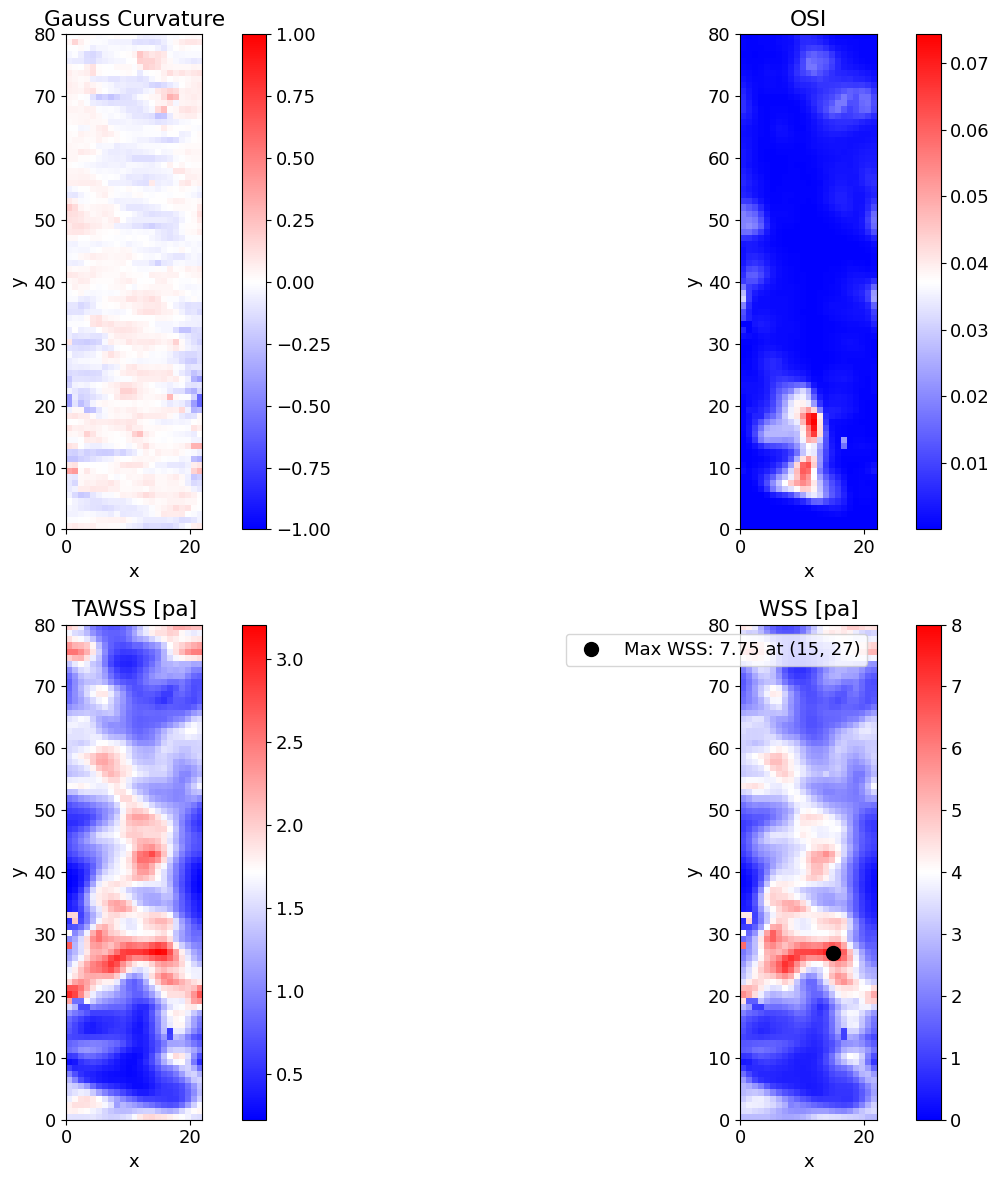

Max WSS value: 7.74759
Max WSS coordinates: (15, 27)


In [75]:
# 加载刚刚生成的 CSV 文件
output_df_loaded = pd.read_csv('CB_mapped_output.csv')  # 请确保路径与生成的 CSV 文件路径一致

# 构造二维网格
x_unique = np.sort(output_df_loaded['x'].unique())  # x轴唯一值
y_unique = np.sort(output_df_loaded['y'].unique())  # y轴唯一值

# 创建参数的二维网格
gauss_curvature_grid = output_df_loaded.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = output_df_loaded.pivot(index='y', columns='x', values='OSI').values
tawss_grid = output_df_loaded.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = output_df_loaded.pivot(index='y', columns='x', values='WSS [pa]').values

# 创建自定义颜色映射
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# 找到最大WSS值及其位置
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (x_unique[wss_max_index[1]], y_unique[wss_max_index[0]])  # 使用x, y的唯一值来获得实际坐标

# 绘制每个参数的图像（保持原来的样式）
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # 设置Gauss Curvature的颜色范围
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-1, vmax=1, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
    elif title == 'WSS [pa]':
        # WSS的颜色范围，并标注最大值
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=8, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
        # 标注最大WSS值及其位置
        ax.plot(max_wss_coordinates[0], max_wss_coordinates[1], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.legend()
    else:
        # 其他参数默认的颜色范围
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# 输出最大WSS值及其坐标
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")


### TB可视化（包括mapping）

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


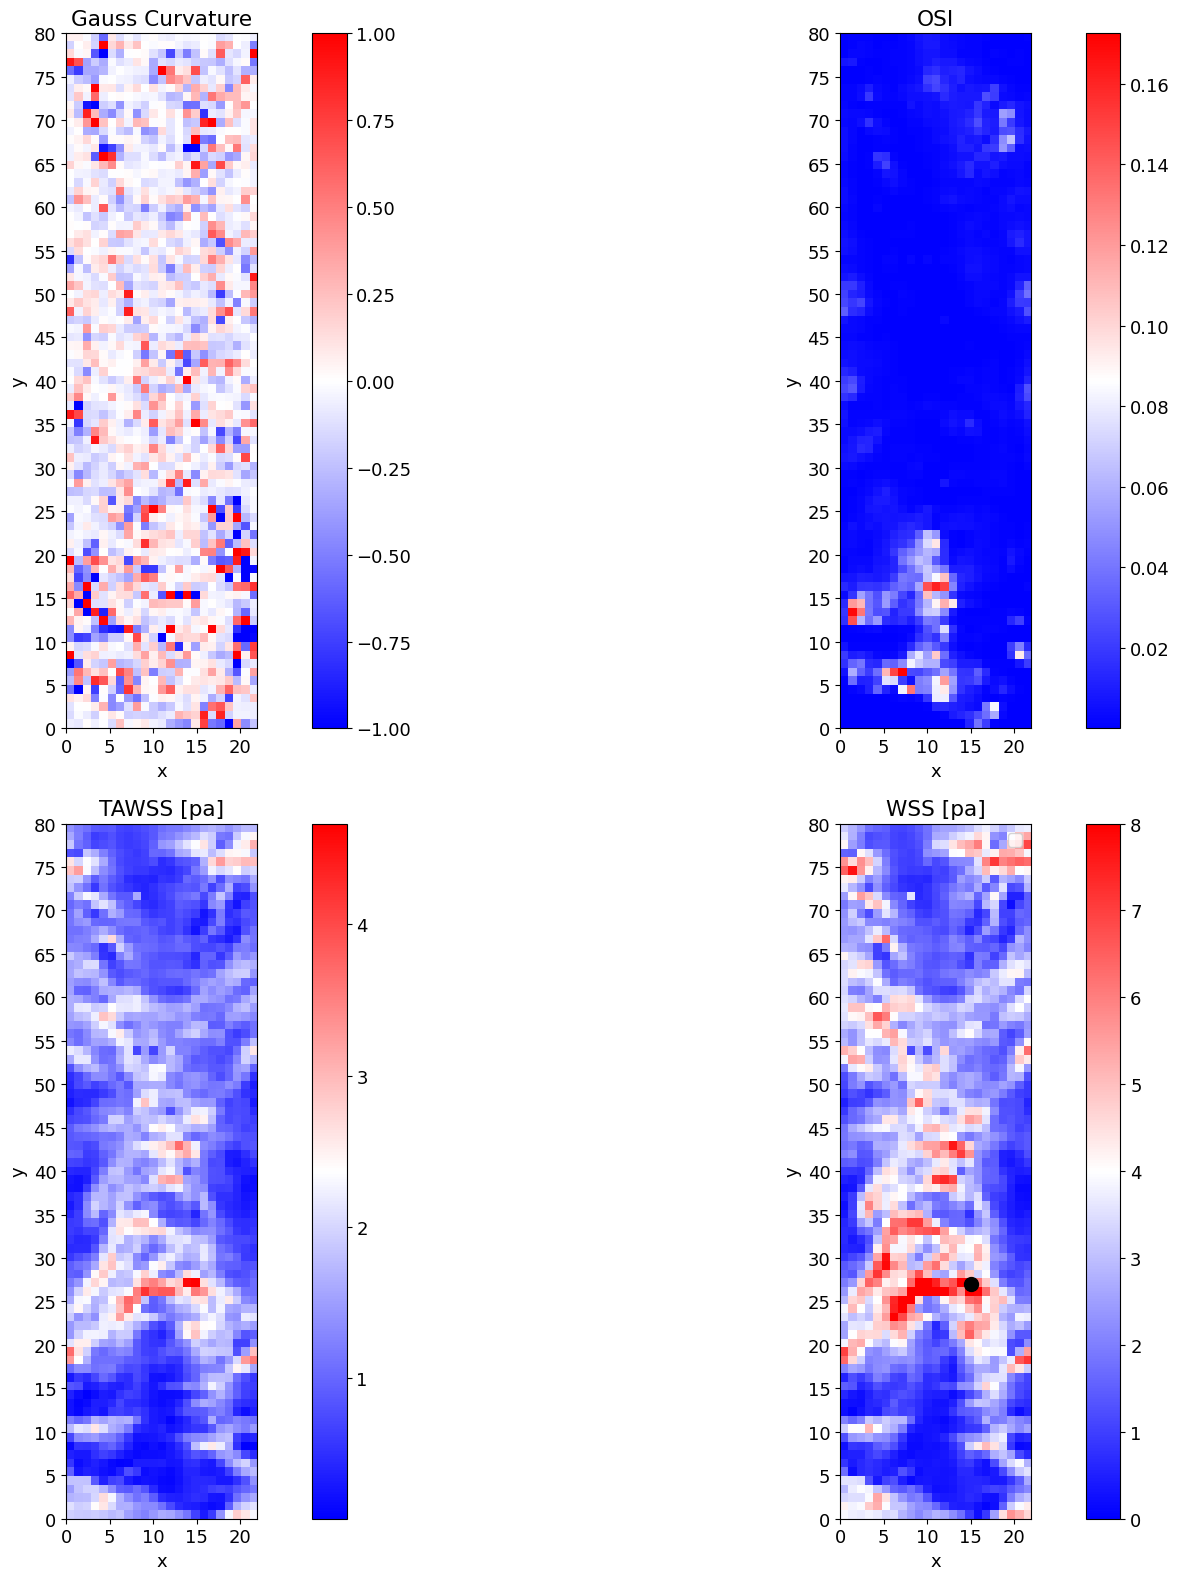

Max WSS value: 10.9438
Max WSS coordinates: (15, 27)


In [89]:
# Set parameters for visualization
a = 26  # Start range for y-axis
b = 106  # End range for y-axis
c = 13  # The x-value to move to x=0
d = 1  # The threshold for Gauss Curvature

# Load the CSV file for analysis
file_path = 'TB_kabayaki.csv'  # 请替换为你的实际文件路径
df = pd.read_csv(file_path)

# Filter y values in the range of a and b
df_filtered = df[(df['y'] >= a) & (df['y'] <= b)].copy()
df_filtered['y'] = df_filtered['y'] - a  # Adjust y values so that 'a' becomes 0

# Process the mapping: flip x-axis and adjust to start from 0
df_c_to_max = df_filtered[df_filtered['x'] >= c].copy()
df_c_to_max['x'] = df_c_to_max['x'] - c  # Move these x values to 0
df_0_to_c = df_filtered[df_filtered['x'] < c].copy()
df_0_to_c['x'] = df_0_to_c['x'] + (df['x'].max() - c + 1)  # Shift these x values to the right

# Flip x-axis values for reverse order
df_c_to_max['x'] = (df['x'].max() - c) - df_c_to_max['x']
df_0_to_c['x'] = (df['x'].max() - c) - df_0_to_c['x']

# Merge the data back together
df_mapped = pd.concat([df_c_to_max, df_0_to_c])

# Handle duplicate entries by averaging the values for duplicate x-y pairs
df_mapped = df_mapped.groupby(['y', 'x'], as_index=False).mean()

# Pivot the dataframe to create 2D arrays for each parameter
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x', values='WSS [pa]').values

# Create a custom colormap: white at 0, blue for lower values, red for higher values
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Find the position of the maximum WSS value and its coordinates based on the new y-axis
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (wss_max_index[1], wss_max_index[0])

# Create a list of titles and grids for plotting
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

# Plot each parameter as a separate subplot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(19, 16))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # Set vmin and vmax for Gauss Curvature to limit the range to -d to d
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-d, vmax=d, extent=(0, len(grid[0]) - 1, 0, b - a))
    elif title == 'WSS [pa]':
        # Set vmin and vmax for WSS
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=e, extent=(0, len(grid[0]) - 1, 0, b - a))
        #ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10)
        ax.legend()
    else:
        # Plot other parameters without limiting the range
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(0, len(grid[0]) - 1, 0, b - a))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Set axis ticks at intervals of 5
    ax.set_xticks(np.arange(0, len(grid[0]), 5))
    ax.set_yticks(np.arange(0, b - a + 1, 5))
    
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# Output max WSS value and coordinates
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")




### TB mapping后csv输出

In [45]:
# 为 `df_mapped` 中的 `x` 轴创建新的翻转列 `x_flipped`
df_mapped['x_flipped'] = (df_mapped['x'].max() - df_mapped['x']).astype(int)

# 生成网格数据，使用翻转后的 x 轴
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x_flipped', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x_flipped', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x_flipped', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x_flipped', values='WSS [pa]').values

# 创建输出的 DataFrame，确保列中的 x 和 y 顺序正确
output_df = pd.DataFrame({
    'y': np.repeat(df_mapped['y'].unique(), len(df_mapped['x_flipped'].unique())),
    'x': np.tile(sorted(df_mapped['x_flipped'].unique(), reverse=True), len(df_mapped['y'].unique())),  # 反转后的 x
    'Gauss_Curvature': gauss_curvature_grid.flatten(),
    'OSI': osi_grid.flatten(),
    'TAWSS [pa]': tawss_grid.flatten(),
    'WSS [pa]': wss_grid.flatten()
})

# 保存为 CSV 文件
output_file_path = 'TB_mapped_output.csv'  # 指定保存路径
output_df.to_csv(output_file_path, index=False)

print(f"CSV 文件已保存至: {output_file_path}")

CSV 文件已保存至: TB_mapped_output.csv


### TB_mapping检查

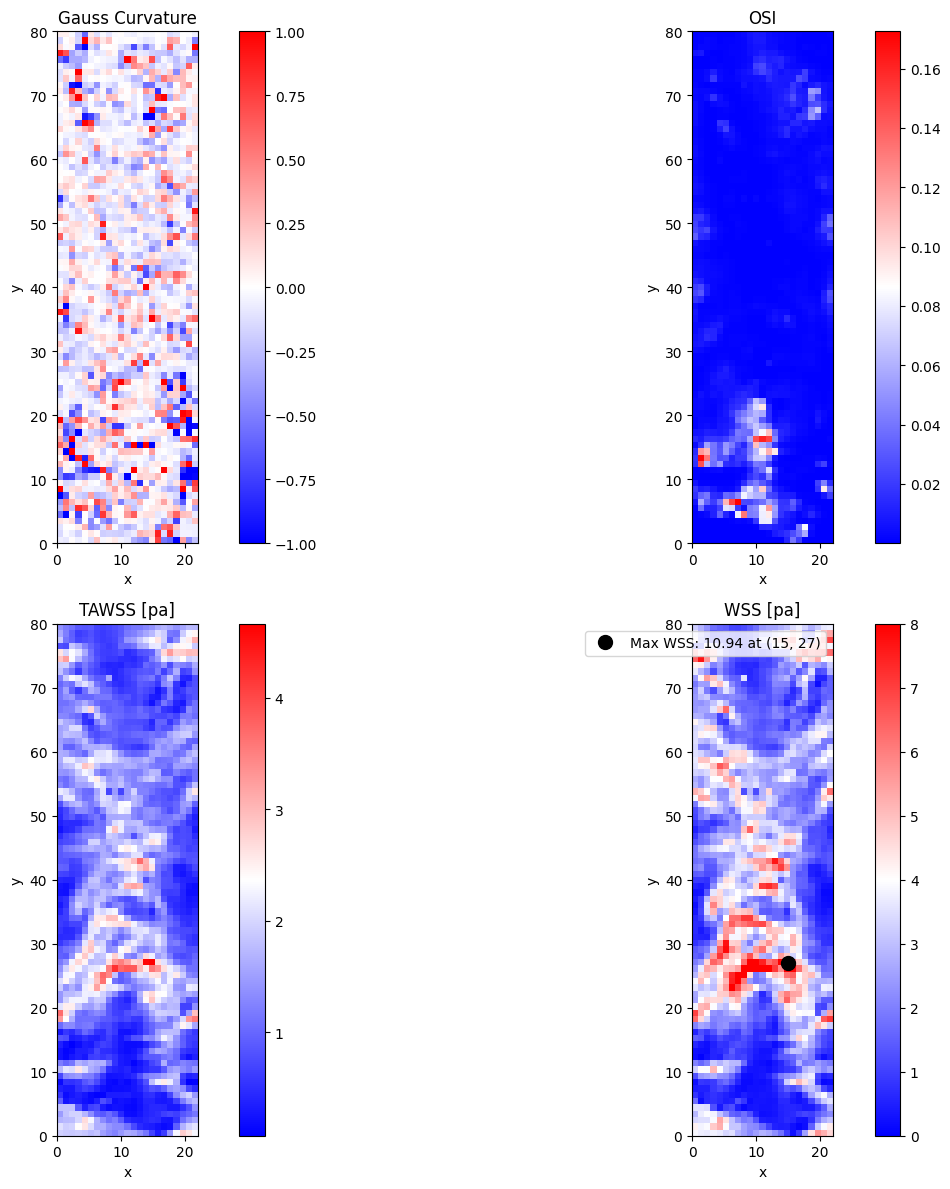

Max WSS value: 10.9438
Max WSS coordinates: (15, 27)


In [46]:
# 加载刚刚生成的 CSV 文件
output_df_loaded = pd.read_csv('TB_mapped_output.csv')  # 请确保路径与生成的 CSV 文件路径一致

# 构造二维网格
x_unique = np.sort(output_df_loaded['x'].unique())  # x轴唯一值
y_unique = np.sort(output_df_loaded['y'].unique())  # y轴唯一值

# 创建参数的二维网格
gauss_curvature_grid = output_df_loaded.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = output_df_loaded.pivot(index='y', columns='x', values='OSI').values
tawss_grid = output_df_loaded.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = output_df_loaded.pivot(index='y', columns='x', values='WSS [pa]').values

# 创建自定义颜色映射
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# 找到最大WSS值及其位置
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (x_unique[wss_max_index[1]], y_unique[wss_max_index[0]])  # 使用x, y的唯一值来获得实际坐标

# 绘制每个参数的图像（保持原来的样式）
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # 设置Gauss Curvature的颜色范围
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-1, vmax=1, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
    elif title == 'WSS [pa]':
        # WSS的颜色范围，并标注最大值
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=8, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
        # 标注最大WSS值及其位置
        ax.plot(max_wss_coordinates[0], max_wss_coordinates[1], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.legend()
    else:
        # 其他参数默认的颜色范围
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# 输出最大WSS值及其坐标
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")


### LP可视化（包括mapping）

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


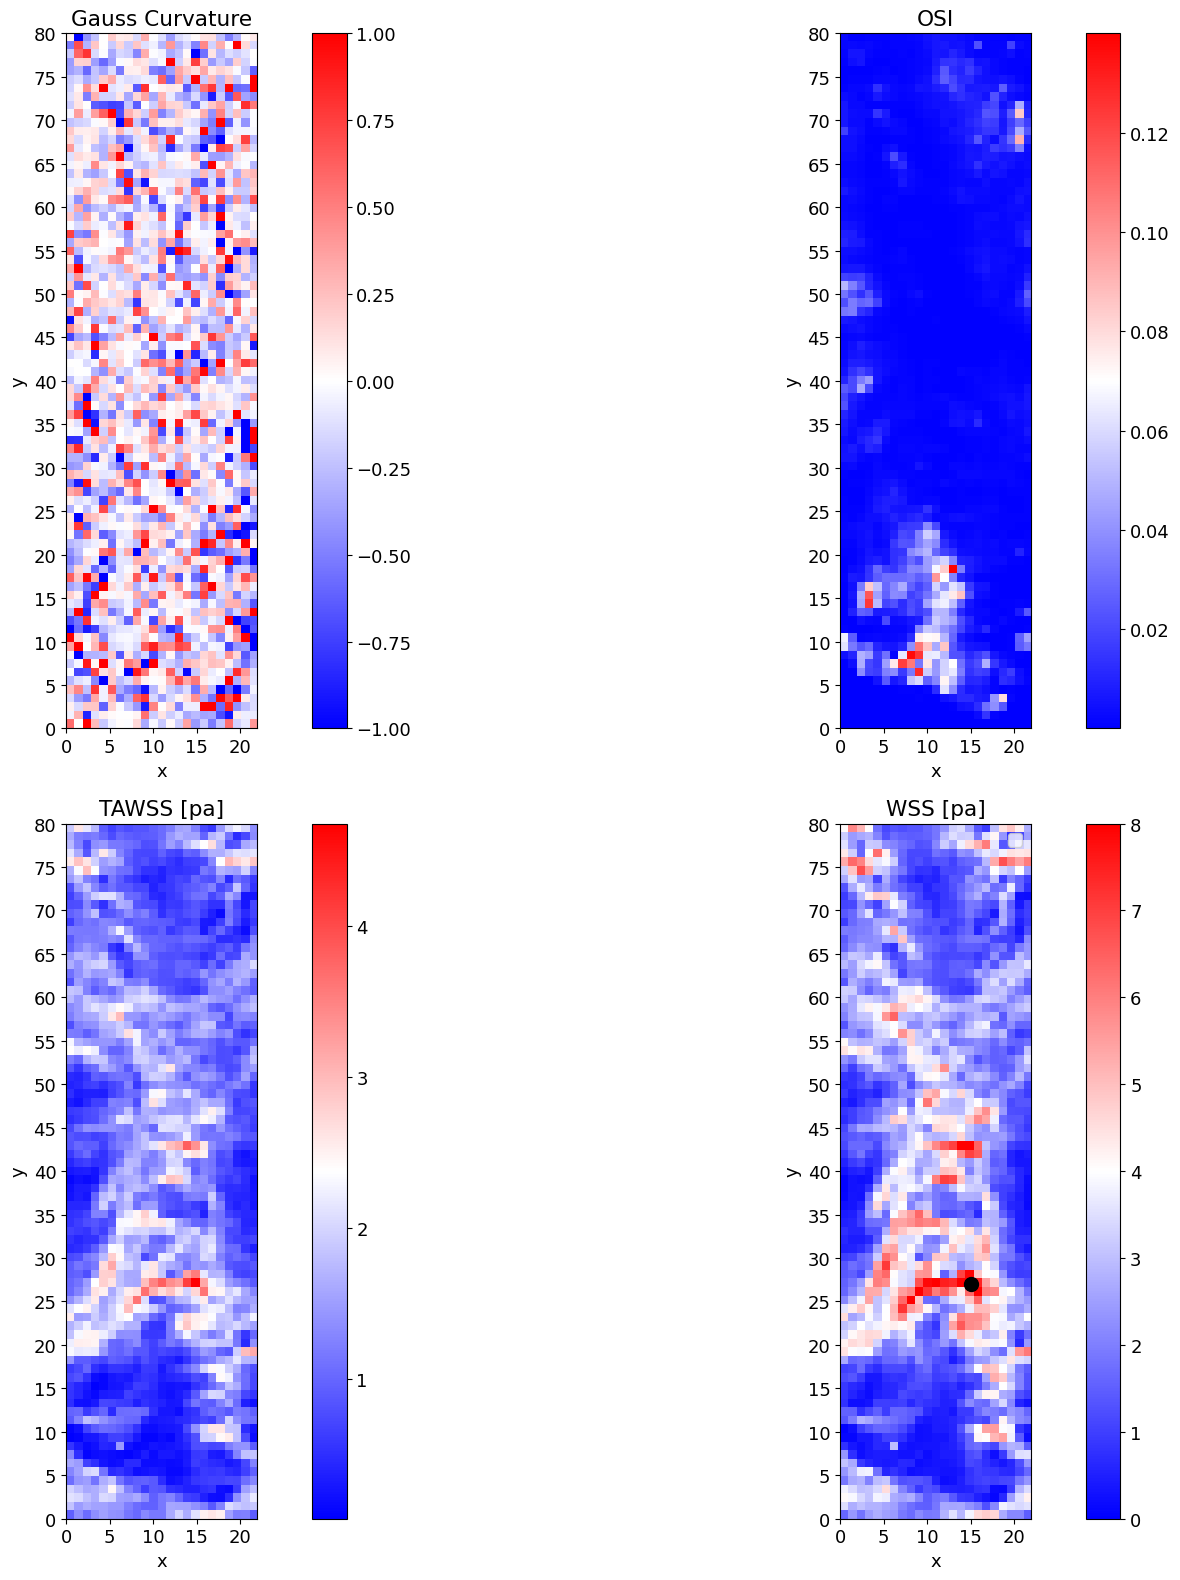

Max WSS value: 11.0777
Max WSS coordinates: (15, 27)


In [91]:
# Set parameters for visualization
a = 19  # Start range for y-axis
b = 99  # End range for y-axis
c = 14  # The x-value to move to x=0
d = 1  # The threshold for Gauss Curvature


# Load the CSV file for analysis
file_path = 'LP_kabayaki.csv'  # 请替换为你的实际文件路径
df = pd.read_csv(file_path)

# Filter y values in the range of a and b
df_filtered = df[(df['y'] >= a) & (df['y'] <= b)].copy()
df_filtered['y'] = df_filtered['y'] - a  # Adjust y values so that 'a' becomes 0

# Process the mapping: flip x-axis and adjust to start from 0
df_c_to_max = df_filtered[df_filtered['x'] >= c].copy()
df_c_to_max['x'] = df_c_to_max['x'] - c  # Move these x values to 0
df_0_to_c = df_filtered[df_filtered['x'] < c].copy()
df_0_to_c['x'] = df_0_to_c['x'] + (df['x'].max() - c + 1)  # Shift these x values to the right

# Flip x-axis values for reverse order
df_c_to_max['x'] = (df['x'].max() - c) - df_c_to_max['x']
df_0_to_c['x'] = (df['x'].max() - c) - df_0_to_c['x']

# Merge the data back together
df_mapped = pd.concat([df_c_to_max, df_0_to_c])

# Handle duplicate entries by averaging the values for duplicate x-y pairs
df_mapped = df_mapped.groupby(['y', 'x'], as_index=False).mean()

# Pivot the dataframe to create 2D arrays for each parameter
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x', values='WSS [pa]').values

# Create a custom colormap: white at 0, blue for lower values, red for higher values
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Find the position of the maximum WSS value and its coordinates based on the new y-axis
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (wss_max_index[1], wss_max_index[0])

# Create a list of titles and grids for plotting
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

# Plot each parameter as a separate subplot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(19, 16))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # Set vmin and vmax for Gauss Curvature to limit the range to -d to d
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-d, vmax=d, extent=(0, len(grid[0]) - 1, 0, b - a))
    elif title == 'WSS [pa]':
        # Set vmin and vmax for WSS
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=e, extent=(0, len(grid[0]) - 1, 0, b - a))
        #ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10)
        ax.legend()
    else:
        # Plot other parameters without limiting the range
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(0, len(grid[0]) - 1, 0, b - a))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Set axis ticks at intervals of 5
    ax.set_xticks(np.arange(0, len(grid[0]), 5))
    ax.set_yticks(np.arange(0, b - a + 1, 5))
    
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# Output max WSS value and coordinates
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")




### LP mapping后csv输出

In [48]:
# 为 `df_mapped` 中的 `x` 轴创建新的翻转列 `x_flipped`
df_mapped['x_flipped'] = (df_mapped['x'].max() - df_mapped['x']).astype(int)

# 生成网格数据，使用翻转后的 x 轴
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x_flipped', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x_flipped', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x_flipped', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x_flipped', values='WSS [pa]').values

# 创建输出的 DataFrame，确保列中的 x 和 y 顺序正确
output_df = pd.DataFrame({
    'y': np.repeat(df_mapped['y'].unique(), len(df_mapped['x_flipped'].unique())),
    'x': np.tile(sorted(df_mapped['x_flipped'].unique(), reverse=True), len(df_mapped['y'].unique())),  # 反转后的 x
    'Gauss_Curvature': gauss_curvature_grid.flatten(),
    'OSI': osi_grid.flatten(),
    'TAWSS [pa]': tawss_grid.flatten(),
    'WSS [pa]': wss_grid.flatten()
})

# 保存为 CSV 文件
output_file_path = 'LP_mapped_output.csv'  # 指定保存路径
output_df.to_csv(output_file_path, index=False)

print(f"CSV 文件已保存至: {output_file_path}")

CSV 文件已保存至: LP_mapped_output.csv


### LP_mapping检查

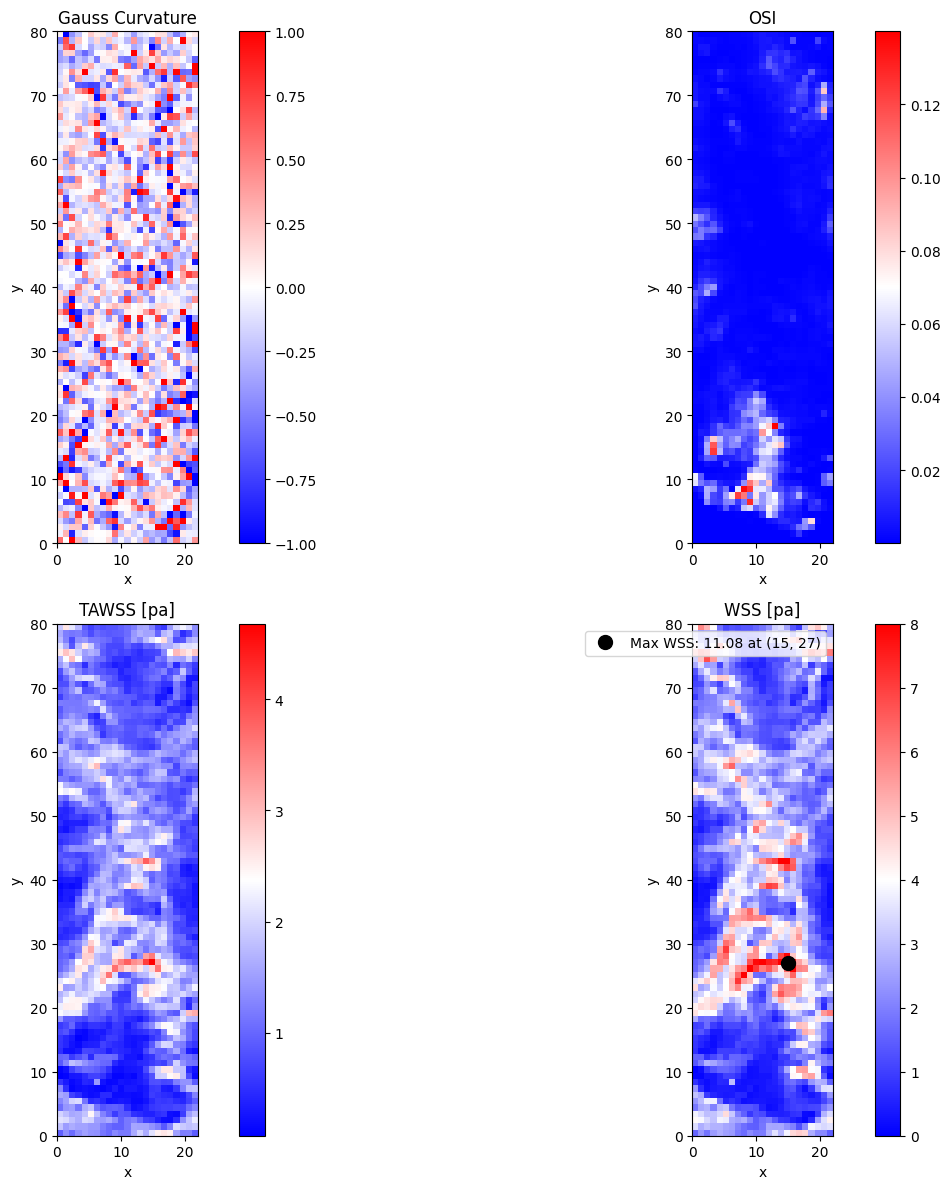

Max WSS value: 11.0777
Max WSS coordinates: (15, 27)


In [49]:
# 加载刚刚生成的 CSV 文件
output_df_loaded = pd.read_csv('LP_mapped_output.csv')  # 请确保路径与生成的 CSV 文件路径一致

# 构造二维网格
x_unique = np.sort(output_df_loaded['x'].unique())  # x轴唯一值
y_unique = np.sort(output_df_loaded['y'].unique())  # y轴唯一值

# 创建参数的二维网格
gauss_curvature_grid = output_df_loaded.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = output_df_loaded.pivot(index='y', columns='x', values='OSI').values
tawss_grid = output_df_loaded.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = output_df_loaded.pivot(index='y', columns='x', values='WSS [pa]').values

# 创建自定义颜色映射
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# 找到最大WSS值及其位置
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (x_unique[wss_max_index[1]], y_unique[wss_max_index[0]])  # 使用x, y的唯一值来获得实际坐标

# 绘制每个参数的图像（保持原来的样式）
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # 设置Gauss Curvature的颜色范围
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-1, vmax=1, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
    elif title == 'WSS [pa]':
        # WSS的颜色范围，并标注最大值
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=8, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
        # 标注最大WSS值及其位置
        ax.plot(max_wss_coordinates[0], max_wss_coordinates[1], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.legend()
    else:
        # 其他参数默认的颜色范围
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# 输出最大WSS值及其坐标
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")


### OR可视化（包括mapping）

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


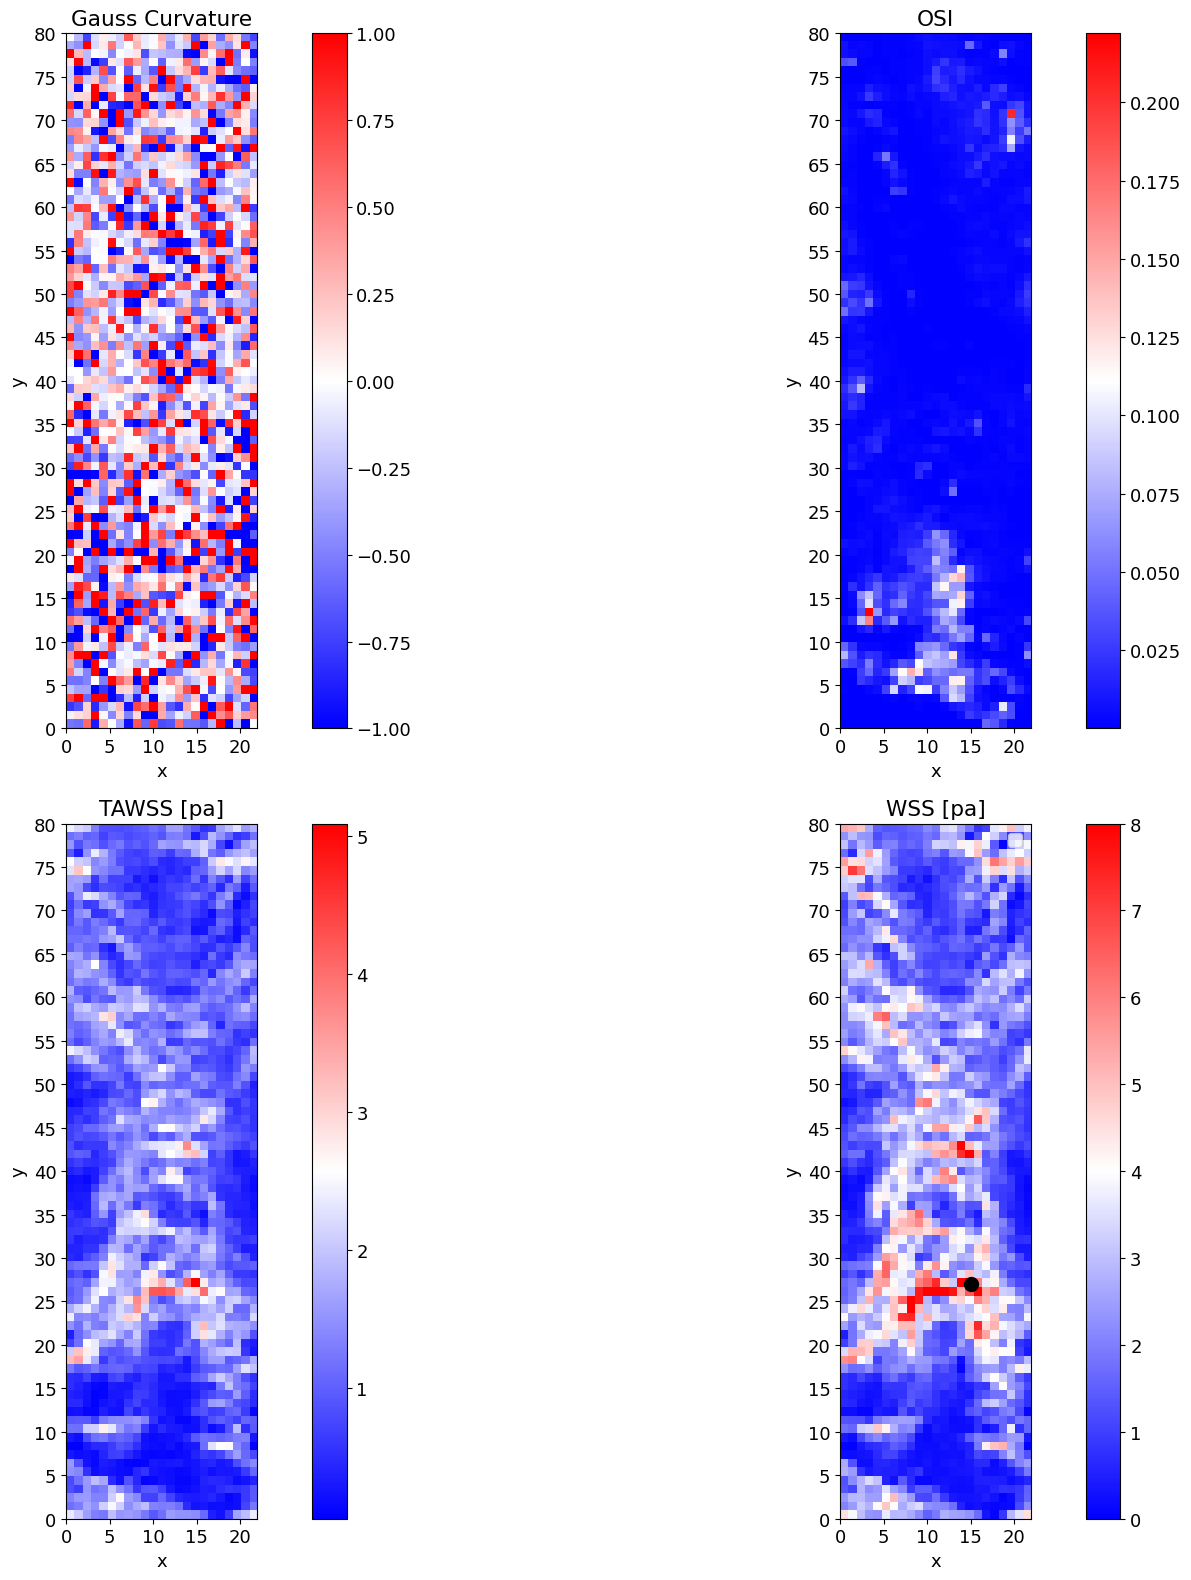

Max WSS value: 11.4839
Max WSS coordinates: (15, 27)


In [93]:
# Set parameters for visualization
a = 21  # Start range for y-axis
b = 101  # End range for y-axis
c = 15  # The x-value to move to x=0
d = 1  # The threshold for Gauss Curvature


# Load the CSV file for analysis
file_path = 'OR_kabayaki.csv'  # 请替换为你的实际文件路径
df = pd.read_csv(file_path)

# Filter y values in the range of a and b
df_filtered = df[(df['y'] >= a) & (df['y'] <= b)].copy()
df_filtered['y'] = df_filtered['y'] - a  # Adjust y values so that 'a' becomes 0

# Process the mapping: flip x-axis and adjust to start from 0
df_c_to_max = df_filtered[df_filtered['x'] >= c].copy()
df_c_to_max['x'] = df_c_to_max['x'] - c  # Move these x values to 0
df_0_to_c = df_filtered[df_filtered['x'] < c].copy()
df_0_to_c['x'] = df_0_to_c['x'] + (df['x'].max() - c + 1)  # Shift these x values to the right

# Flip x-axis values for reverse order
df_c_to_max['x'] = (df['x'].max() - c) - df_c_to_max['x']
df_0_to_c['x'] = (df['x'].max() - c) - df_0_to_c['x']

# Merge the data back together
df_mapped = pd.concat([df_c_to_max, df_0_to_c])

# Handle duplicate entries by averaging the values for duplicate x-y pairs
df_mapped = df_mapped.groupby(['y', 'x'], as_index=False).mean()

# Pivot the dataframe to create 2D arrays for each parameter
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x', values='WSS [pa]').values

# Create a custom colormap: white at 0, blue for lower values, red for higher values
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# Find the position of the maximum WSS value and its coordinates based on the new y-axis
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (wss_max_index[1], wss_max_index[0])

# Create a list of titles and grids for plotting
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

# Plot each parameter as a separate subplot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(19, 16))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # Set vmin and vmax for Gauss Curvature to limit the range to -d to d
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-d, vmax=d, extent=(0, len(grid[0]) - 1, 0, b - a))
    elif title == 'WSS [pa]':
        # Set vmin and vmax for WSS
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=e, extent=(0, len(grid[0]) - 1, 0, b - a))
        #ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.plot(wss_max_index[1], wss_max_index[0], 'ko', markersize=10)
        ax.legend()
    else:
        # Plot other parameters without limiting the range
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(0, len(grid[0]) - 1, 0, b - a))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # Set axis ticks at intervals of 5
    ax.set_xticks(np.arange(0, len(grid[0]), 5))
    ax.set_yticks(np.arange(0, b - a + 1, 5))
    
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# Output max WSS value and coordinates
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")





### OR mapping后csv输出

In [94]:
# 为 `df_mapped` 中的 `x` 轴创建新的翻转列 `x_flipped`
df_mapped['x_flipped'] = (df_mapped['x'].max() - df_mapped['x']).astype(int)

# 生成网格数据，使用翻转后的 x 轴
gauss_curvature_grid = df_mapped.pivot(index='y', columns='x_flipped', values='Gauss_Curvature').values
osi_grid = df_mapped.pivot(index='y', columns='x_flipped', values='OSI').values
tawss_grid = df_mapped.pivot(index='y', columns='x_flipped', values='TAWSS [pa]').values
wss_grid = df_mapped.pivot(index='y', columns='x_flipped', values='WSS [pa]').values

# 创建输出的 DataFrame，确保列中的 x 和 y 顺序正确
output_df = pd.DataFrame({
    'y': np.repeat(df_mapped['y'].unique(), len(df_mapped['x_flipped'].unique())),
    'x': np.tile(sorted(df_mapped['x_flipped'].unique(), reverse=True), len(df_mapped['y'].unique())),  # 反转后的 x
    'Gauss_Curvature': gauss_curvature_grid.flatten(),
    'OSI': osi_grid.flatten(),
    'TAWSS [pa]': tawss_grid.flatten(),
    'WSS [pa]': wss_grid.flatten()
})

# 保存为 CSV 文件
output_file_path = 'OR_mapped_output.csv'  # 指定保存路径
output_df.to_csv(output_file_path, index=False)

print(f"CSV 文件已保存至: {output_file_path}")

CSV 文件已保存至: OR_mapped_output.csv


### OR_mapping检查

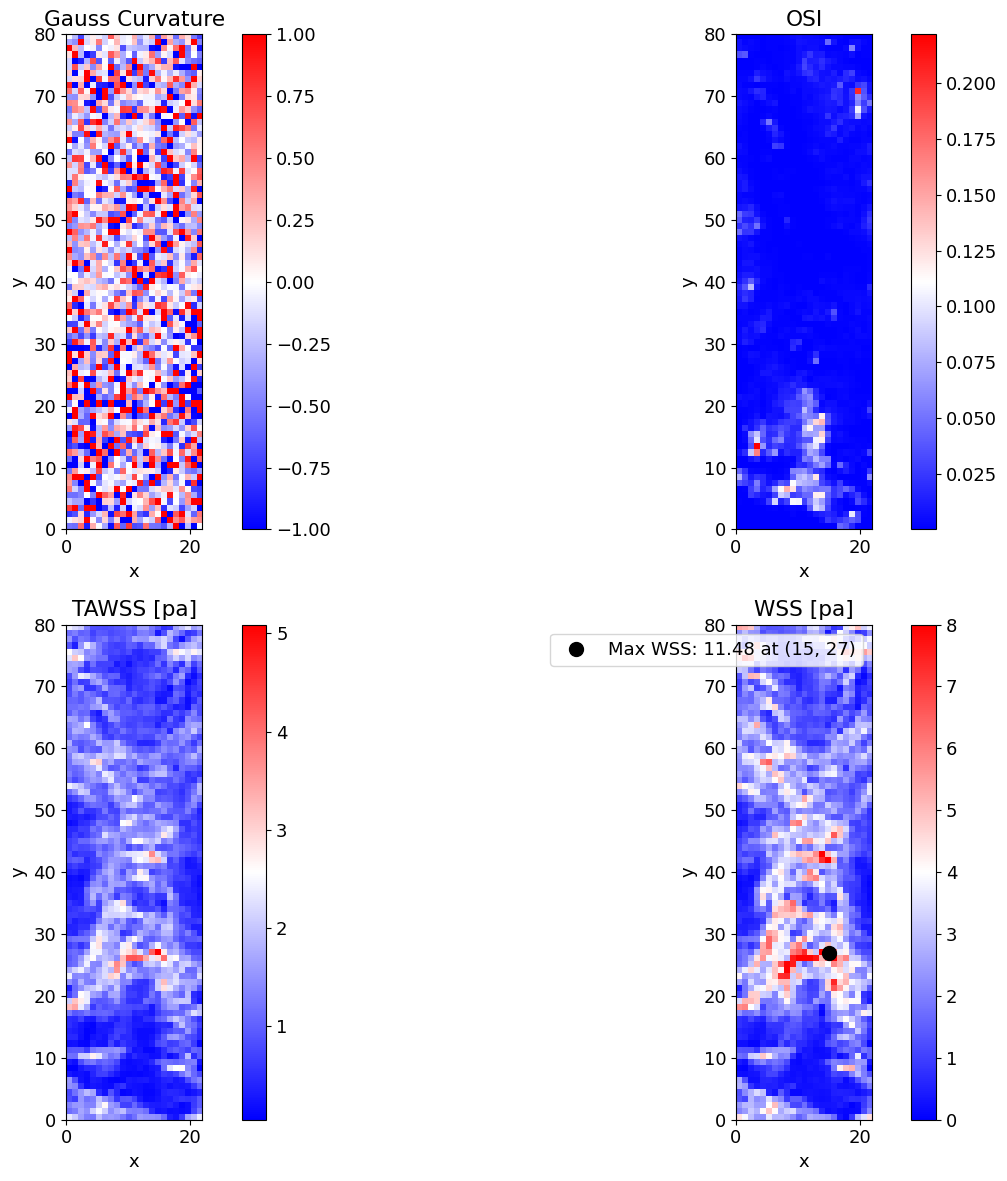

Max WSS value: 11.4839
Max WSS coordinates: (15, 27)


In [95]:
# 加载刚刚生成的 CSV 文件
output_df_loaded = pd.read_csv('OR_mapped_output.csv')  # 请确保路径与生成的 CSV 文件路径一致

# 构造二维网格
x_unique = np.sort(output_df_loaded['x'].unique())  # x轴唯一值
y_unique = np.sort(output_df_loaded['y'].unique())  # y轴唯一值

# 创建参数的二维网格
gauss_curvature_grid = output_df_loaded.pivot(index='y', columns='x', values='Gauss_Curvature').values
osi_grid = output_df_loaded.pivot(index='y', columns='x', values='OSI').values
tawss_grid = output_df_loaded.pivot(index='y', columns='x', values='TAWSS [pa]').values
wss_grid = output_df_loaded.pivot(index='y', columns='x', values='WSS [pa]').values

# 创建自定义颜色映射
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# 找到最大WSS值及其位置
wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
max_wss_value = wss_grid[wss_max_index]
max_wss_coordinates = (x_unique[wss_max_index[1]], y_unique[wss_max_index[0]])  # 使用x, y的唯一值来获得实际坐标

# 绘制每个参数的图像（保持原来的样式）
titles = ['Gauss Curvature', 'OSI', 'TAWSS [pa]', 'WSS [pa]']
grids = [gauss_curvature_grid, osi_grid, tawss_grid, wss_grid]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for ax, title, grid in zip(axes.ravel(), titles, grids):
    if title == 'Gauss Curvature':
        # 设置Gauss Curvature的颜色范围
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=-1, vmax=1, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
    elif title == 'WSS [pa]':
        # WSS的颜色范围，并标注最大值
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=8, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
        # 标注最大WSS值及其位置
        ax.plot(max_wss_coordinates[0], max_wss_coordinates[1], 'ko', markersize=10, label=f'Max WSS: {max_wss_value:.2f} at {max_wss_coordinates}')
        ax.legend()
    else:
        # 其他参数默认的颜色范围
        c = ax.imshow(grid, origin='lower', aspect='equal', cmap=custom_cmap, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
    
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()

# 输出最大WSS值及其坐标
print(f"Max WSS value: {max_wss_value}")
print(f"Max WSS coordinates: {max_wss_coordinates}")


### 一起比较

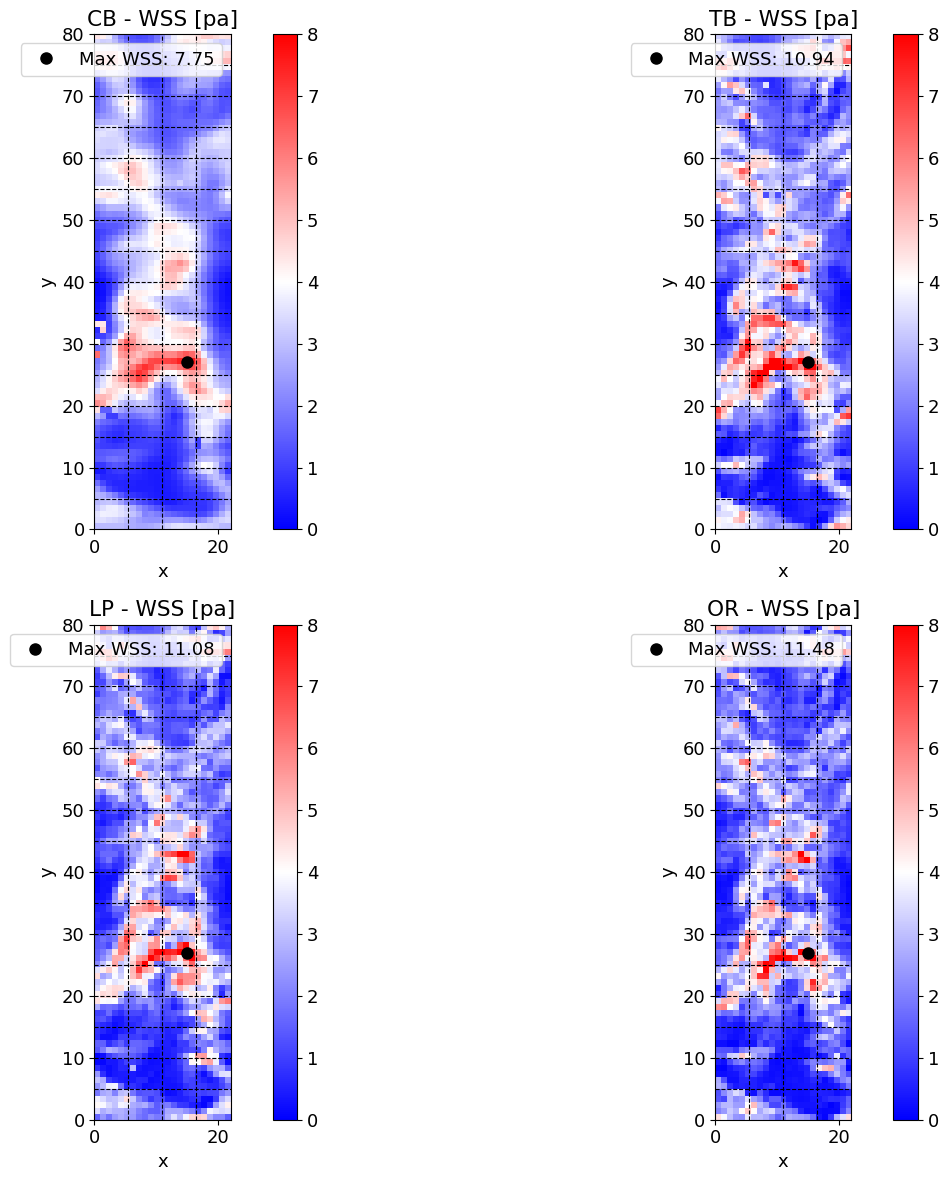

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 定义四个 CSV 文件的路径
file_paths = ['CB_mapped_output.csv', 'TB_mapped_output.csv', 'LP_mapped_output.csv', 'OR_mapped_output.csv']  # 替换为实际路径
titles = ['CB', 'TB', 'LP', 'OR']

# 自定义颜色映射
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# 创建2x2布局以绘制四个文档的WSS图
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 逐个加载文件并处理
for ax, file_path, title in zip(axes.ravel(), file_paths, titles):
    # 加载数据
    output_df_loaded = pd.read_csv(file_path)
    
    # 获取 x 和 y 的唯一值
    x_unique = np.sort(output_df_loaded['x'].unique())
    y_unique = np.sort(output_df_loaded['y'].unique())
    
    # 创建 WSS 网格
    wss_grid = output_df_loaded.pivot(index='y', columns='x', values='WSS [pa]').values
    
    # 找到最大 WSS 值及其位置
    wss_max_index = np.unravel_index(np.argmax(wss_grid, axis=None), wss_grid.shape)
    max_wss_value = wss_grid[wss_max_index]
    max_wss_coordinates = (x_unique[wss_max_index[1]], y_unique[wss_max_index[0]])  # 实际坐标
    
    # 绘制 WSS 图
    c = ax.imshow(wss_grid, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=8, extent=(x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max()))
    
    # 标注最大WSS值的位置
    ax.plot(max_wss_coordinates[0], max_wss_coordinates[1], 'ko', markersize=8, label=f'Max WSS: {max_wss_value:.2f}')
    ax.legend()
    ax.set_title(f'{title} - WSS [pa]')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    # 计算分割线的间隔
    x_interval = (x_unique.max() - x_unique.min()) / 4
    y_interval = (y_unique.max() - y_unique.min()) / 16

    # 添加水平和垂直分割线
    for i in range(1, 4):  # 4 等分，3 条垂直线
        ax.axvline(x=x_unique.min() + i * x_interval, color='black', linestyle='--', linewidth=0.8)
    for j in range(1, 16):  # 16 等分，15 条水平线
        ax.axhline(y=y_unique.min() + j * y_interval, color='black', linestyle='--', linewidth=0.8)
    
    fig.colorbar(c, ax=ax)

plt.tight_layout()
plt.show()


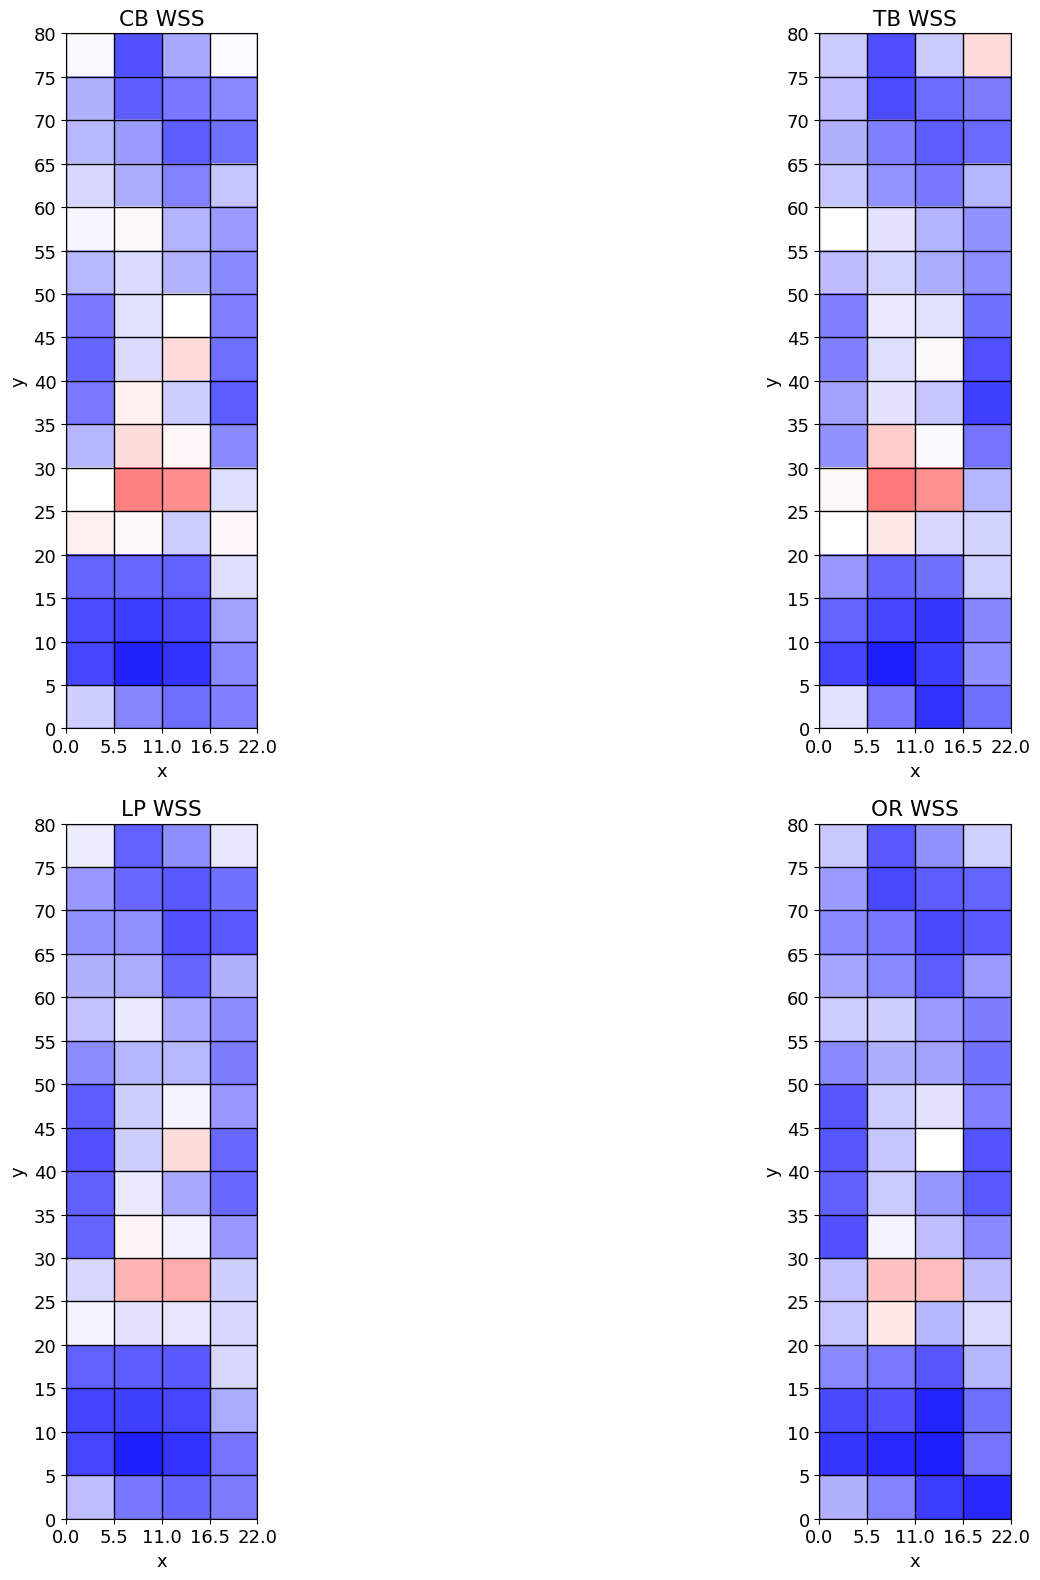

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 定义四个 CSV 文件的路径
file_paths = ['CB_mapped_output.csv', 'TB_mapped_output.csv', 'LP_mapped_output.csv', 'OR_mapped_output.csv']  # 替换为实际路径
titles = ['CB', 'TB', 'LP', 'OR']

# 分块的数量
x_sections = 4
y_sections = 16

# 自定义颜色映射
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# 设置可视化的图形尺寸
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 逐个加载文件并处理
for file_path, title, ax in zip(file_paths, titles, axes.ravel()):
    # 加载数据
    output_df_loaded = pd.read_csv(file_path)
    
    # 获取 x 和 y 的唯一值
    x_unique = np.sort(output_df_loaded['x'].unique())
    y_unique = np.sort(output_df_loaded['y'].unique())
    
    # 定义分块间隔
    x_interval = (x_unique.max() - x_unique.min()) / x_sections
    y_interval = (y_unique.max() - y_unique.min()) / y_sections
    
    # 初始化存储分块平均值的列表
    section_means = np.zeros((y_sections, x_sections))
    
    # 计算每个分块的平均值
    for i in range(x_sections):
        for j in range(y_sections):
            # 定义当前分块的边界
            x_min = x_unique.min() + i * x_interval
            x_max = x_unique.min() + (i + 1) * x_interval
            y_min = y_unique.min() + j * y_interval
            y_max = y_unique.min() + (j + 1) * y_interval
            
            # 筛选分块内的数据
            section_data = output_df_loaded[
                (output_df_loaded['x'] >= x_min) & (output_df_loaded['x'] < x_max) &
                (output_df_loaded['y'] >= y_min) & (output_df_loaded['y'] < y_max)
            ]
            
            # 计算当前分块的WSS平均值
            section_means[j, i] = section_data['WSS [pa]'].mean() if not section_data.empty else np.nan

    # 可视化分块的平均 WSS 值，模拟 2D 原图布局
    extent = (x_unique.min(), x_unique.max(), y_unique.min(), y_unique.max())
    c = ax.imshow(section_means, origin='lower', aspect='equal', cmap=custom_cmap, vmin=0, vmax=8, extent=extent)
    ax.set_title(f"{title} WSS")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    # 设置坐标轴和网格
    ax.set_xticks(np.linspace(x_unique.min(), x_unique.max(), x_sections + 1))
    ax.set_yticks(np.linspace(y_unique.min(), y_unique.max(), y_sections + 1))
    ax.grid(which="major", color="black", linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()


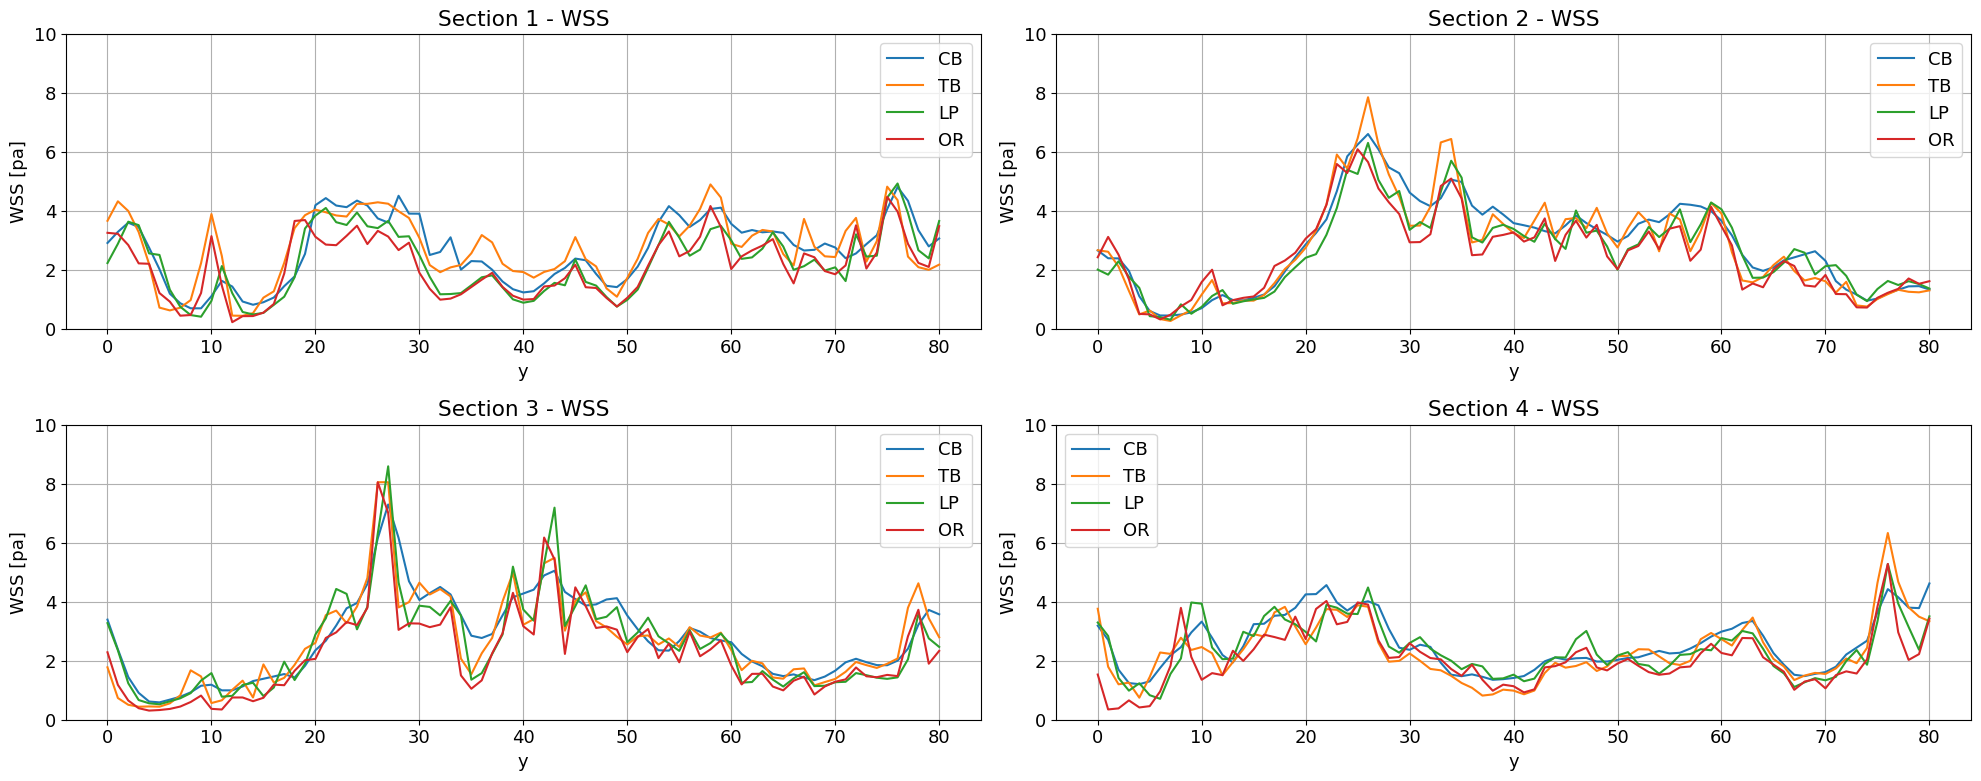

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 定义四个 CSV 文件的路径
file_paths = ['CB_mapped_output.csv', 'TB_mapped_output.csv', 'LP_mapped_output.csv', 'OR_mapped_output.csv']  # 替换为实际路径
titles = ['CB', 'TB', 'LP', 'OR']

# 分块的数量
x_sections = 4
y_sections = 16

# 设置可视化图形尺寸
fig, axes = plt.subplots(2, 2, figsize=(20, 8))
axes = axes.ravel()

# 逐个处理每个 x 区段
for section_idx in range(x_sections):
    ax = axes[section_idx]
    
    # 遍历每个模型并处理数据
    for file_path, title in zip(file_paths, titles):
        # 加载数据
        output_df_loaded = pd.read_csv(file_path)
        
        # 获取 x 和 y 的唯一值
        x_unique = np.sort(output_df_loaded['x'].unique())
        y_unique = np.sort(output_df_loaded['y'].unique())
        
        # 定义 x 区段范围
        x_interval = (x_unique.max() - x_unique.min()) / x_sections
        x_min = x_unique.min() + section_idx * x_interval
        x_max = x_unique.min() + (section_idx + 1) * x_interval
        
        # 存储当前 x 区段的 WSS 平均值
        y_mean_wss = []
        
        # 遍历每个 y 值，计算当前 x 区段的平均 WSS 值
        for y_value in y_unique:
            section_data = output_df_loaded[
                (output_df_loaded['x'] >= x_min) & (output_df_loaded['x'] < x_max) &
                (output_df_loaded['y'] == y_value)
            ]
            # 计算平均 WSS 值
            avg_wss = section_data['WSS [pa]'].mean() if not section_data.empty else np.nan
            y_mean_wss.append(avg_wss)
        
        # 绘制当前模型的折线图
        ax.plot(y_unique, y_mean_wss, label=title)
    
    # 设置图例、标题和固定的纵轴范围
    ax.set_title(f"Section {section_idx + 1} - WSS")
    ax.set_xlabel("y")
    ax.set_ylabel("WSS [pa]")
    ax.set_ylim(0, 10)  # 固定纵坐标范围在 0 到 10
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


### 特定部位的输出

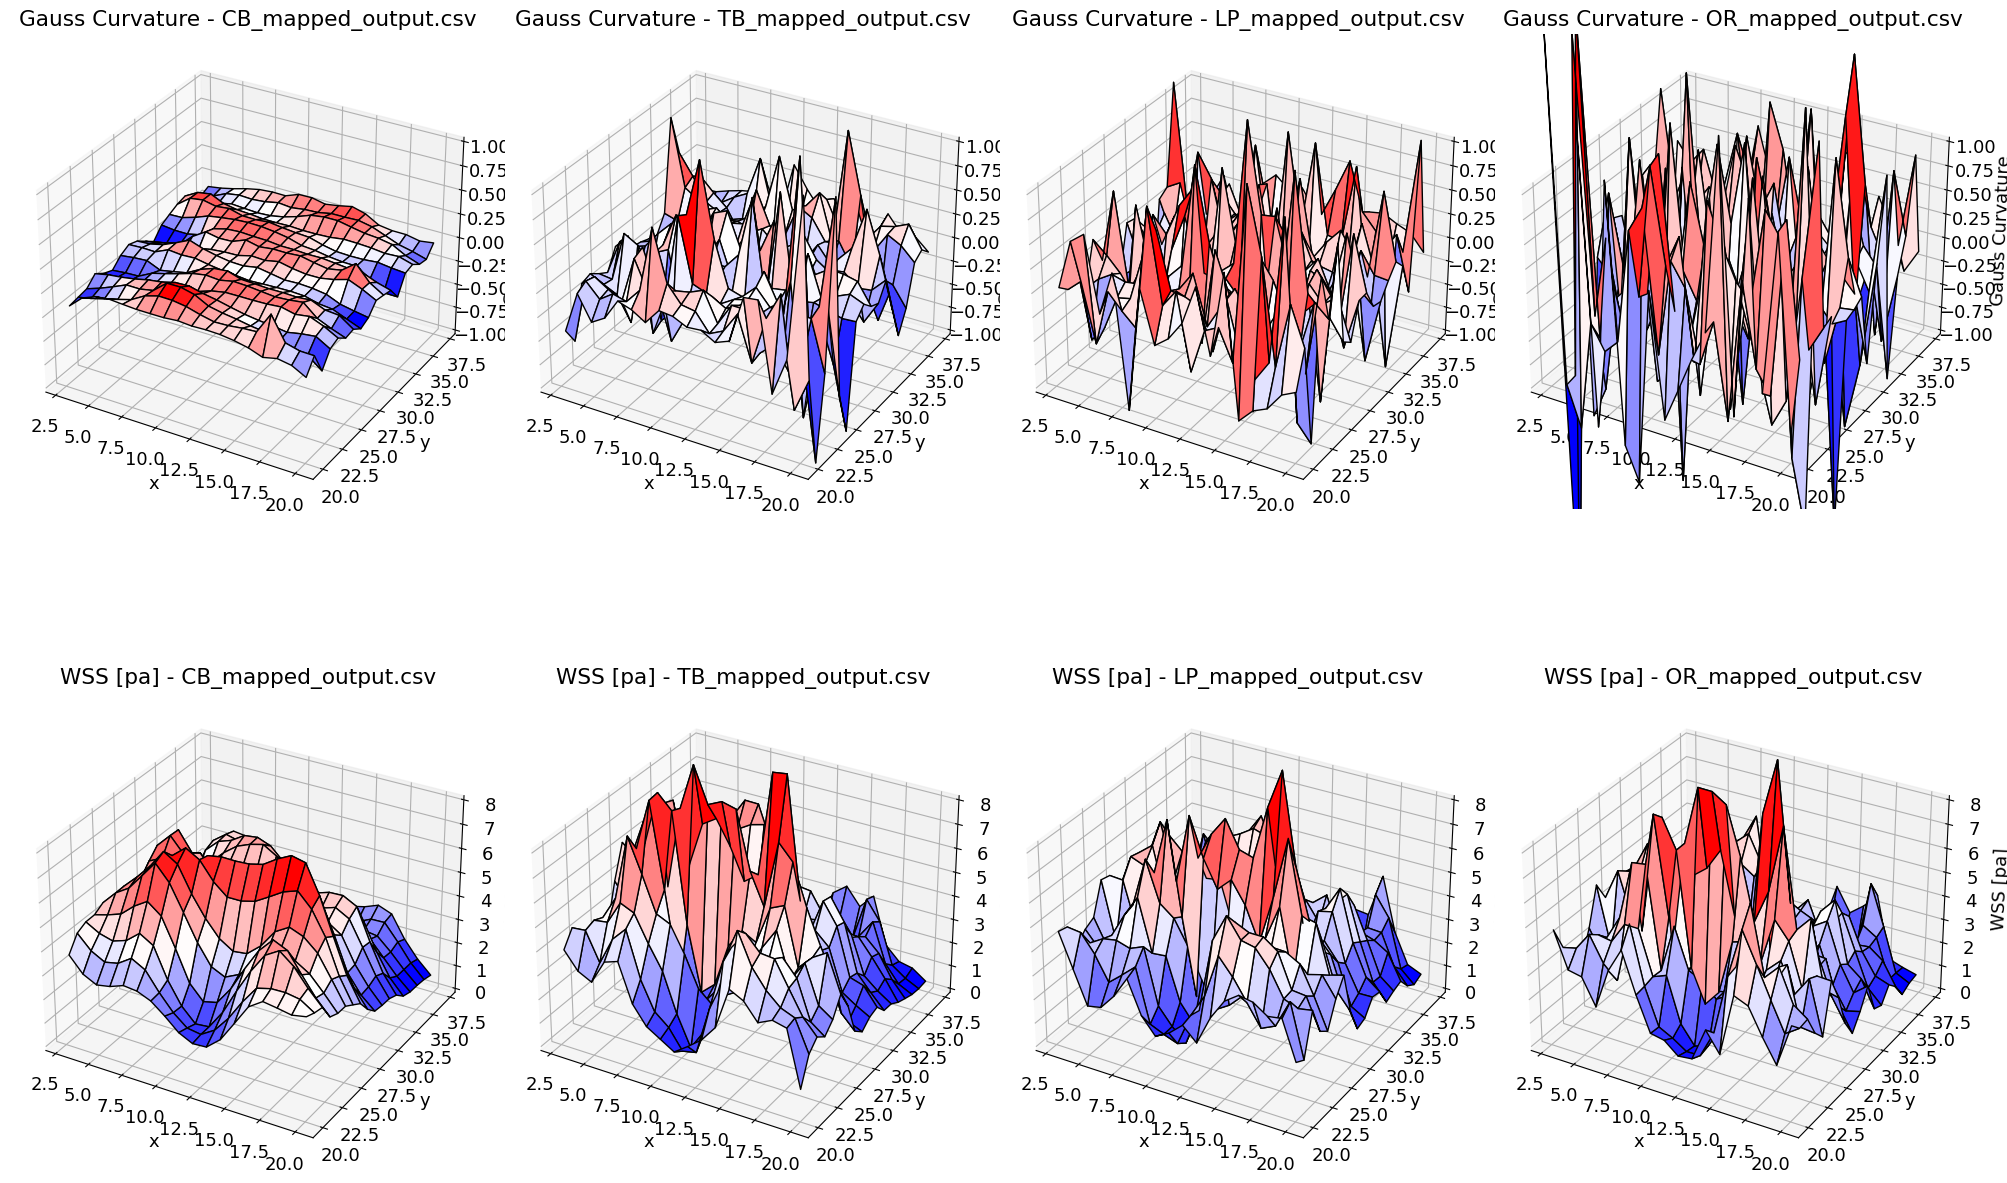

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

# 定义四个 CSV 文档的路径
file_paths = ['CB_mapped_output.csv', 'TB_mapped_output.csv', 'LP_mapped_output.csv', 'OR_mapped_output.csv']  # 请替换为实际文件路径

# 定义要可视化的范围
x_start, x_end = 3, 20  # 横轴范围
y_start, y_end = 20, 37  # 纵轴范围

# 用于存储数据的列表
gauss_grids = []  # 存储 Gaussian 曲率的网格数据
wss_grids = []    # 存储 WSS 的网格数据

# 读取每个 CSV 文件，筛选指定范围的数据
for file_path in file_paths:
    df = pd.read_csv(file_path)
    
    # 筛选指定范围的 x 和 y 数据
    df_filtered = df[(df['x'] >= x_start) & (df['x'] <= x_end) & (df['y'] >= y_start) & (df['y'] <= y_end)]
    
    # 将筛选后的数据重新构造为二维网格
    x_unique = np.sort(df_filtered['x'].unique())  # 获取 x 的唯一值
    y_unique = np.sort(df_filtered['y'].unique())  # 获取 y 的唯一值
    X, Y = np.meshgrid(x_unique, y_unique)  # 创建网格
    
    # 根据不同的参数创建二维网格
    if 'Gauss_Curvature' in df_filtered.columns:
        gauss_grid = df_filtered.pivot(index='y', columns='x', values='Gauss_Curvature').values
        gauss_grids.append((gauss_grid, X, Y, file_path))  # 存储 Gauss Curvature 的网格数据
    if 'WSS [pa]' in df_filtered.columns:
        wss_grid = df_filtered.pivot(index='y', columns='x', values='WSS [pa]').values
        wss_grids.append((wss_grid, X, Y, file_path))  # 存储 WSS 的网格数据

# 创建自定义颜色映射
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# 设置全局字体大小
plt.rcParams.update({'font.size': 13})

# 创建2x4的子图布局，第一行为 Gauss Curvature 3D 图，第二行为 WSS 3D 图
fig = plt.figure(figsize=(20, 15))

# 绘制 Gauss Curvature 的 3D 图
for i, (grid, X, Y, file_name) in enumerate(gauss_grids, start=1):
    ax = fig.add_subplot(2, 4, i, projection='3d')
    ax.plot_surface(X, Y, grid, cmap=custom_cmap, edgecolor='k', rstride=1, cstride=1)
    ax.set_title(f'Gauss Curvature - {file_name}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Gauss Curvature')
    ax.set_zlim(-1, 1)  # 设置 Gauss Curvature 的范围

# 绘制 WSS 的 3D 图
for i, (grid, X, Y, file_name) in enumerate(wss_grids, start=5):
    ax = fig.add_subplot(2, 4, i, projection='3d')
    ax.plot_surface(X, Y, grid, cmap=custom_cmap, edgecolor='k', rstride=1, cstride=1)
    ax.set_title(f'WSS [pa] - {file_name}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('WSS [pa]')
    ax.set_zlim(0, 8)  # 设置 WSS 的范围

plt.tight_layout()
plt.show()


### 保存设定部分数据

In [54]:
custom_names = ['CB', 'TB', 'LP', 'OR']  # 自定义名字

# 用于存储所有数据的 DataFrame
all_data = pd.DataFrame()

# 读取每个 CSV 文件，筛选指定范围的数据并提取高斯曲率和 WSS
for file_path, name in zip(file_paths, custom_names):
    df = pd.read_csv(file_path)
    
    # 筛选指定范围的 x 和 y 数据
    df_filtered = df[(df['x'] >= x_start) & (df['x'] <= x_end) & (df['y'] >= y_start) & (df['y'] <= y_end)]
    
    # 提取高斯曲率和 WSS 列，并重命名以区分文档
    df_filtered = df_filtered[['x', 'y', 'Gauss_Curvature', 'WSS [pa]']].copy()
    df_filtered.rename(columns={
        'Gauss_Curvature': f'{name}_Gauss_Curvature',
        'WSS [pa]': f'{name}_WSS [pa]'
    }, inplace=True)
    
    # 合并每个文档的数据到总的 DataFrame
    if all_data.empty:
        all_data = df_filtered
    else:
        # 按照 x 和 y 进行合并，保留所有数据
        all_data = pd.merge(all_data, df_filtered, on=['x', 'y'], how='outer')

# 保存到 CSV 文件
output_file = 'all_part_WSS_GC.csv'
all_data.to_csv(output_file, index=False)



### 特定部为的比较

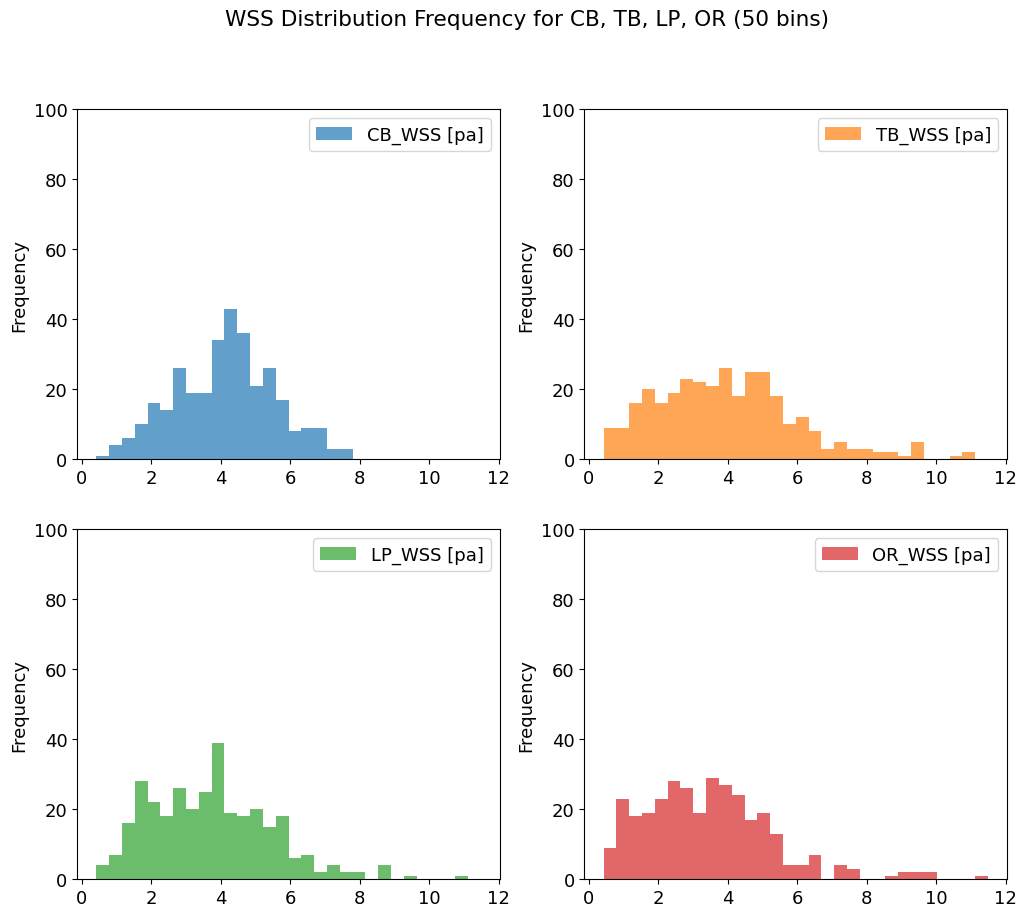

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
file_path = 'all_part_WSS_GC.csv'  # 替换为你的实际文件路径
df = pd.read_csv(file_path)

# 提取 CB、TB、LP 和 OR 的 WSS 列
wss_columns = ['CB_WSS [pa]', 'TB_WSS [pa]', 'LP_WSS [pa]', 'OR_WSS [pa]']
wss_data = df[wss_columns]

# 绘制每列的分布频率直方图，并独立显示每个图的横轴和统一的纵轴范围
axes = wss_data.plot(kind='hist', subplots=True, layout=(2, 2), bins=30, alpha=0.7, figsize=(12, 10), legend=True, sharex=False)

# 设置每个子图的纵轴范围为 0 到 70
for ax in axes.flatten():
    ax.set_ylim(0, 100)

plt.suptitle("WSS Distribution Frequency for CB, TB, LP, OR (50 bins)")
plt.show()



### 数据处理

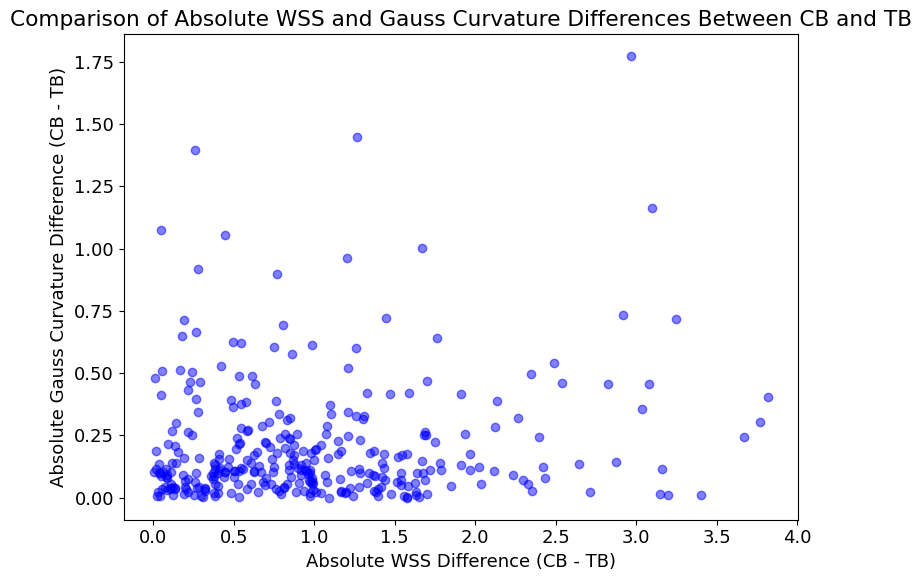

In [56]:
# 读取已合并的数据
file_path = 'all_part_WSS_GC.csv'  # 替换为实际文件路径
df = pd.read_csv(file_path)

# 计算 CB 和 TB 的 WSS 和 高斯曲率的差值的绝对值
df['WSS_abs_diff'] = np.abs(df['CB_WSS [pa]'] - df['TB_WSS [pa]'])  # WSS 绝对差值
df['Gauss_Curvature_abs_diff'] = np.abs(df['CB_Gauss_Curvature'] - df['TB_Gauss_Curvature'])  # 高斯曲率绝对差值

# 绘制点图，横轴为 WSS 差值，纵轴为高斯曲率差值
plt.figure(figsize=(8, 6))
plt.scatter(df['WSS_abs_diff'], df['Gauss_Curvature_abs_diff'], c='blue', alpha=0.5)

# 添加标签和标题
plt.xlabel('Absolute WSS Difference (CB - TB)')
plt.ylabel('Absolute Gauss Curvature Difference (CB - TB)')
plt.title('Comparison of Absolute WSS and Gauss Curvature Differences Between CB and TB')

# 显示图像
plt.tight_layout()
plt.show()


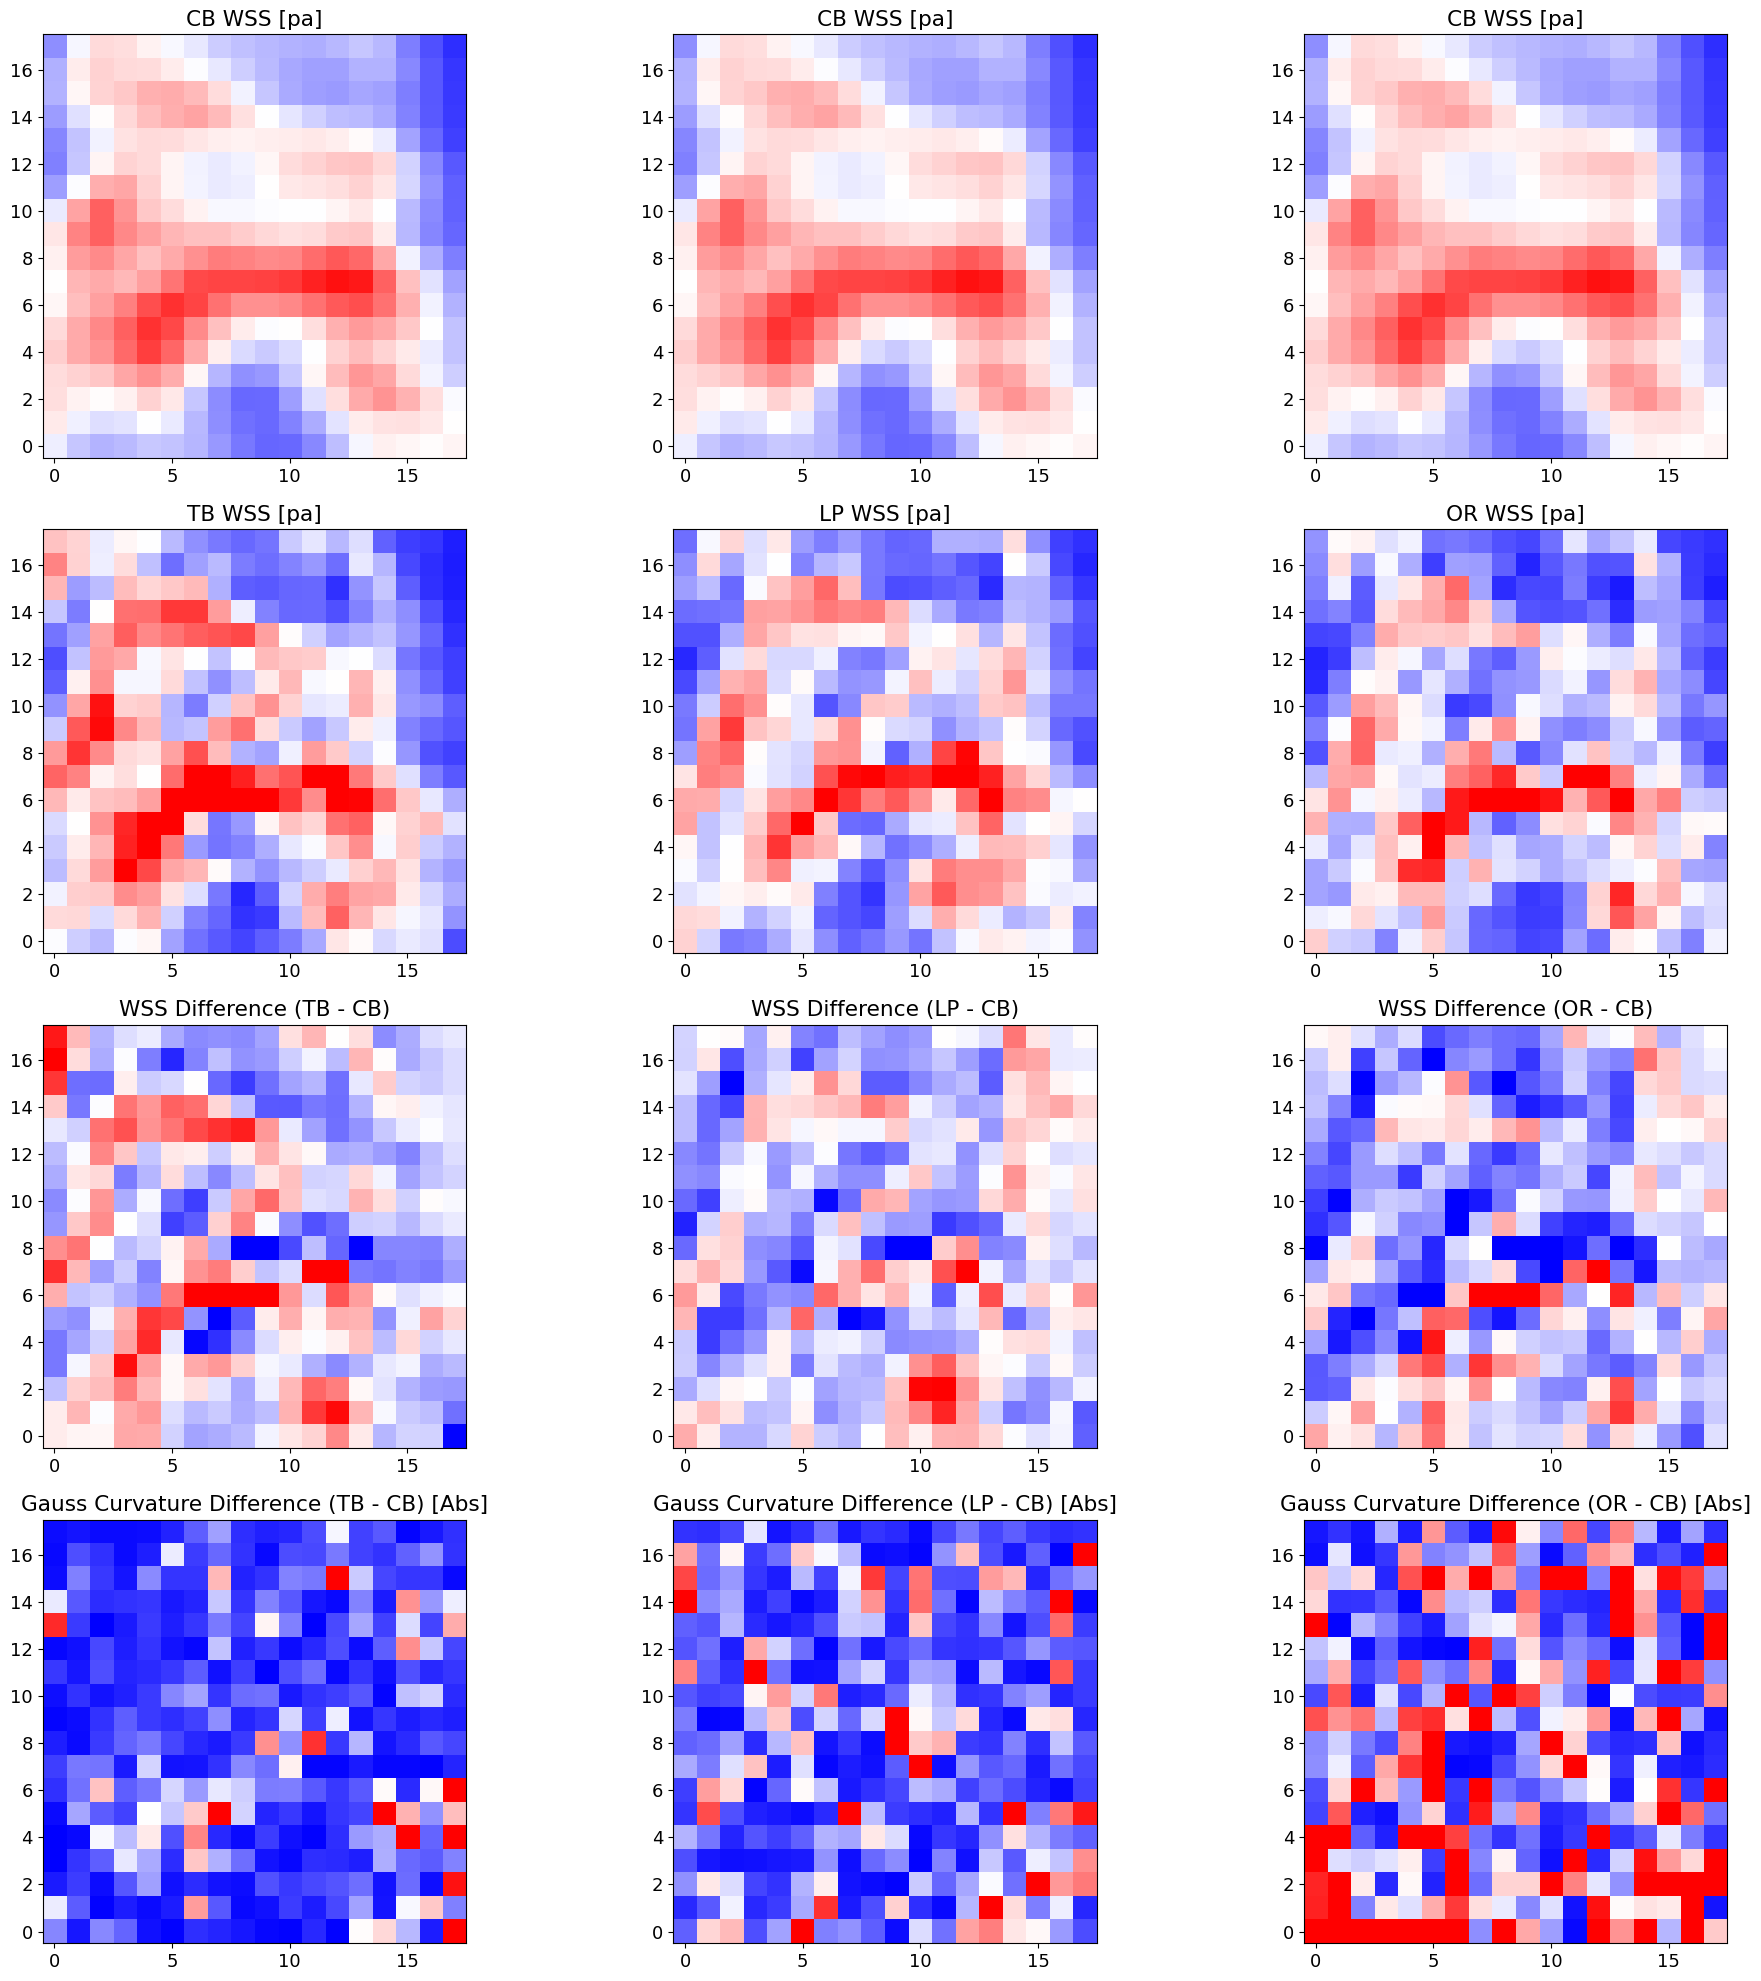

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 读取已合并的数据
file_path = 'all_part_WSS_GC.csv'  # 替换为实际文件路径
df = pd.read_csv(file_path)

# 计算 CB 与 TB、LP、OR 的 WSS 和 高斯曲率 差值
df['WSS_diff_TB'] = df['TB_WSS [pa]'] - df['CB_WSS [pa]']  # WSS 差值 (TB - CB)
df['WSS_diff_LP'] = df['LP_WSS [pa]'] - df['CB_WSS [pa]']  # WSS 差值 (LP - CB)
df['WSS_diff_OR'] = df['OR_WSS [pa]'] - df['CB_WSS [pa]']  # WSS 差值 (OR - CB)

# 计算高斯曲率差值的绝对值
df['Gauss_Curvature_diff_TB'] = np.abs(df['TB_Gauss_Curvature'] - df['CB_Gauss_Curvature'])  # 高斯曲率 差值绝对值 (TB - CB)
df['Gauss_Curvature_diff_LP'] = np.abs(df['LP_Gauss_Curvature'] - df['CB_Gauss_Curvature'])  # 高斯曲率 差值绝对值 (LP - CB)
df['Gauss_Curvature_diff_OR'] = np.abs(df['OR_Gauss_Curvature'] - df['CB_Gauss_Curvature'])  # 高斯曲率 差值绝对值 (OR - CB)

# 设定统一的范围
a = 8  # WSS 的最大值范围
b = 3  # WSS 差值的范围
c = 1  # 高斯曲率差值的范围

# 创建自定义颜色映射
colors = ['blue', 'white', 'red']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

# 创建4x3的子图布局
fig, axes = plt.subplots(4, 3, figsize=(20, 20))  # 4行3列的图

# 第一行：显示CB的WSS
axes[0, 0].imshow(df.pivot(index='y', columns='x', values='CB_WSS [pa]'), cmap=custom_cmap, origin='lower', vmin=0, vmax=a)
axes[0, 0].set_title('CB WSS [pa]')
axes[0, 1].imshow(df.pivot(index='y', columns='x', values='CB_WSS [pa]'), cmap=custom_cmap, origin='lower', vmin=0, vmax=a)
axes[0, 1].set_title('CB WSS [pa]')
axes[0, 2].imshow(df.pivot(index='y', columns='x', values='CB_WSS [pa]'), cmap=custom_cmap, origin='lower', vmin=0, vmax=a)
axes[0, 2].set_title('CB WSS [pa]')

# 第二行：显示TB, LP, OR 的 WSS
axes[1, 0].imshow(df.pivot(index='y', columns='x', values='TB_WSS [pa]'), cmap=custom_cmap, origin='lower', vmin=0, vmax=a)
axes[1, 0].set_title('TB WSS [pa]')
axes[1, 1].imshow(df.pivot(index='y', columns='x', values='LP_WSS [pa]'), cmap=custom_cmap, origin='lower', vmin=0, vmax=a)
axes[1, 1].set_title('LP WSS [pa]')
axes[1, 2].imshow(df.pivot(index='y', columns='x', values='OR_WSS [pa]'), cmap=custom_cmap, origin='lower', vmin=0, vmax=a)
axes[1, 2].set_title('OR WSS [pa]')

# 第三行：显示WSS差值 (TB - CB, LP - CB, OR - CB)
axes[2, 0].imshow(df.pivot(index='y', columns='x', values='WSS_diff_TB'), cmap=custom_cmap, origin='lower', vmin=-b, vmax=b)
axes[2, 0].set_title('WSS Difference (TB - CB)')
axes[2, 1].imshow(df.pivot(index='y', columns='x', values='WSS_diff_LP'), cmap=custom_cmap, origin='lower', vmin=-b, vmax=b)
axes[2, 1].set_title('WSS Difference (LP - CB)')
axes[2, 2].imshow(df.pivot(index='y', columns='x', values='WSS_diff_OR'), cmap=custom_cmap, origin='lower', vmin=-b, vmax=b)
axes[2, 2].set_title('WSS Difference (OR - CB)')

# 第四行：显示高斯曲率差值 (TB - CB, LP - CB, OR - CB)，使用绝对值
axes[3, 0].imshow(df.pivot(index='y', columns='x', values='Gauss_Curvature_diff_TB'), cmap=custom_cmap, origin='lower', vmin=0, vmax=c)
axes[3, 0].set_title('Gauss Curvature Difference (TB - CB) [Abs]')
axes[3, 1].imshow(df.pivot(index='y', columns='x', values='Gauss_Curvature_diff_LP'), cmap=custom_cmap, origin='lower', vmin=0, vmax=c)
axes[3, 1].set_title('Gauss Curvature Difference (LP - CB) [Abs]')
axes[3, 2].imshow(df.pivot(index='y', columns='x', values='Gauss_Curvature_diff_OR'), cmap=custom_cmap, origin='lower', vmin=0, vmax=c)
axes[3, 2].set_title('Gauss Curvature Difference (OR - CB) [Abs]')

plt.tight_layout()
plt.show()


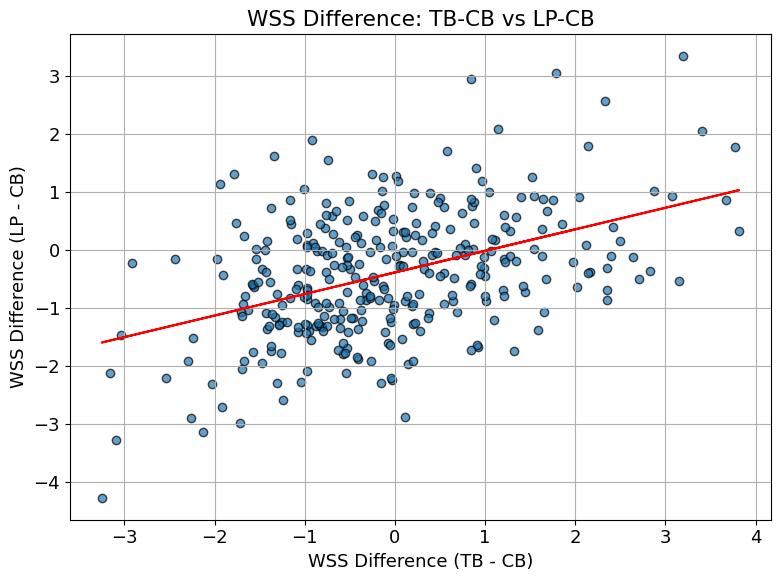

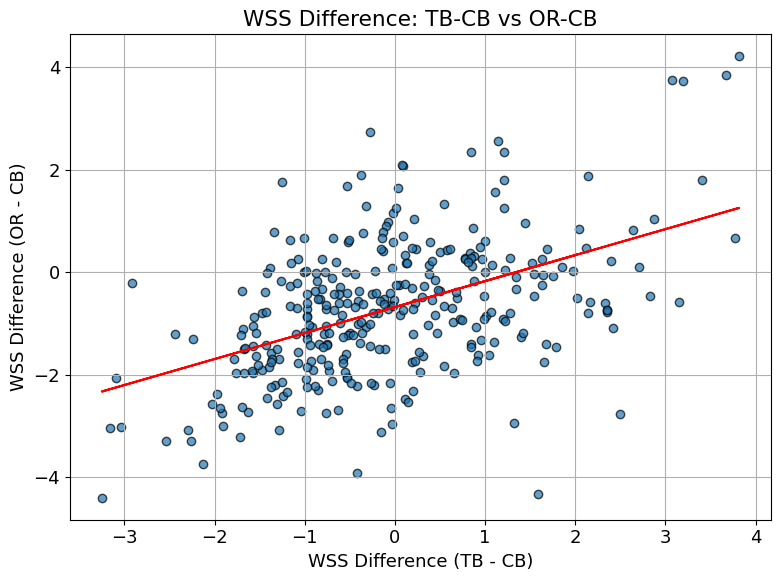

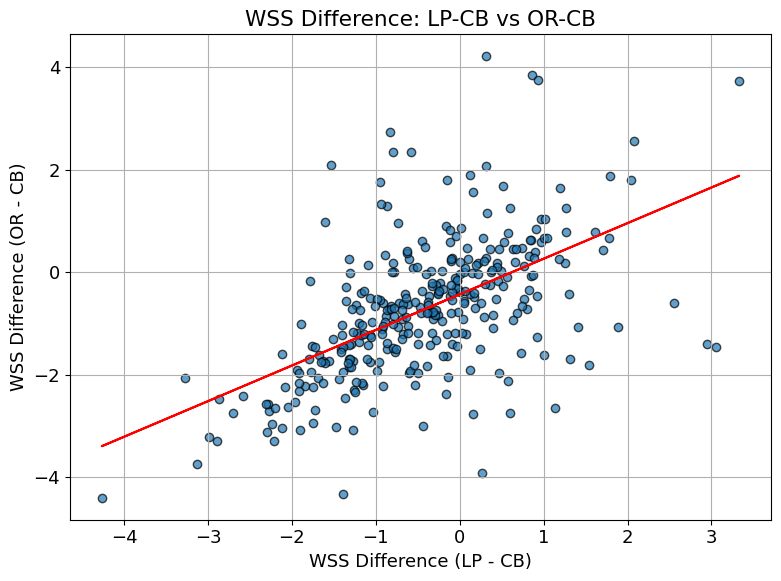

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取已合并的数据
file_path = 'all_part_WSS_GC.csv'  # 替换为实际文件路径
df = pd.read_csv(file_path)

# 计算 CB 与 TB、LP、OR 的 WSS 差值
df['WSS_diff_TB'] = df['TB_WSS [pa]'] - df['CB_WSS [pa]']  # WSS 差值 (TB - CB)
df['WSS_diff_LP'] = df['LP_WSS [pa]'] - df['CB_WSS [pa]']  # WSS 差值 (LP - CB)
df['WSS_diff_OR'] = df['OR_WSS [pa]'] - df['CB_WSS [pa]']  # WSS 差值 (OR - CB)

# 创建散点图并添加拟合线 (TB - CB vs LP - CB)
plt.figure(figsize=(8, 6))
plt.scatter(df['WSS_diff_TB'], df['WSS_diff_LP'], alpha=0.7, edgecolors='k')

# 拟合线
fit_tb_lp = np.polyfit(df['WSS_diff_TB'], df['WSS_diff_LP'], 1)
p_tb_lp = np.poly1d(fit_tb_lp)
plt.plot(df['WSS_diff_TB'], p_tb_lp(df['WSS_diff_TB']), color='red')

plt.title('WSS Difference: TB-CB vs LP-CB')
plt.xlabel('WSS Difference (TB - CB)')
plt.ylabel('WSS Difference (LP - CB)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 创建散点图并添加拟合线 (TB - CB vs OR - CB)
plt.figure(figsize=(8, 6))
plt.scatter(df['WSS_diff_TB'], df['WSS_diff_OR'], alpha=0.7, edgecolors='k')

# 拟合线
fit_tb_or = np.polyfit(df['WSS_diff_TB'], df['WSS_diff_OR'], 1)
p_tb_or = np.poly1d(fit_tb_or)
plt.plot(df['WSS_diff_TB'], p_tb_or(df['WSS_diff_TB']), color='red')

plt.title('WSS Difference: TB-CB vs OR-CB')
plt.xlabel('WSS Difference (TB - CB)')
plt.ylabel('WSS Difference (OR - CB)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 创建散点图并添加拟合线 (LP - CB vs OR - CB)
plt.figure(figsize=(8, 6))
plt.scatter(df['WSS_diff_LP'], df['WSS_diff_OR'], alpha=0.7, edgecolors='k')

# 拟合线
fit_lp_or = np.polyfit(df['WSS_diff_LP'], df['WSS_diff_OR'], 1)
p_lp_or = np.poly1d(fit_lp_or)
plt.plot(df['WSS_diff_LP'], p_lp_or(df['WSS_diff_LP']), color='red')

plt.title('WSS Difference: LP-CB vs OR-CB')
plt.xlabel('WSS Difference (LP - CB)')
plt.ylabel('WSS Difference (OR - CB)')
plt.grid(True)
plt.tight_layout()
plt.show()
